# Domain Adaptation Tutorial for the MAX78000

# **1. Introduction**
---

## **1.1 Setup**
*This tutorial assumes you already have the ai8x-training, ai8x-synthesis, and sdk repos configured as shown [here](https://github.com/geffenc/DA_ai8x-training#installation). In addition to that setup, we need to install and configure Jupyter notebook within the virtual environment as shown [here](https://github.com/geffenc/DA_ai8x-training/blob/89f809b960a22b07a6de054837ad88b5c07241c2/DA_tutorial/Jupyter_setup.md).*

---

## **1.2 Notebook Navigation**
Unfortunately internal links to other sections of the notebook don't seem to work in Visual Studio Code which makes it more difficult to navigate through sections in the notebook. However, Visual Studio Code does provide an *OUTLINE* of the notebook at the bottom left corner which can be used to jump to certain sections as shown in this image. The different sections will be numbered so they can quickly be found in the outline.

<center>

![outline](images/Picture3.png)

</center>

---

## **1.3 Context**: what is domain adaptation and why do we need it?
CNN models have been very successful at image classification tasks when trained on large labeled datasets. However, when deploying these CNN models on real systems (i.e. the MAX78000) for live inference, the model accuracy can drop significantly due to differences in the data distribution seen at test time and at training time. For example, the training data might be high quality images with good lighting while data seen during inference might be coming from a low quality sensor or an environment with variable conditions.  

A few examples of this *domain shift* are shown below where the ***source** domain* represents images from a dataset and the ***target** domain* represents images from the MAX7800's onboard camera. As shown, images from the target domain may be lower quality, noisy, have diferent backgrounds, and have different object orientation and aspect ratio.

<center>

| | Mug | Backpack | Monitor | Keyboard |
| :----: | :----: | :----: | :----: | :----: |
| **Source** Domain | ![Dataset Mug](images/mug_source.jpg) | ![Dataset Backpack](images/backpack_source.jpg) | ![Dataset Monitor](images/monitor_source.jpg) | ![Dataset Keyboard](images/keyboard_source.jpg) |
| **Target** Domain | ![Camera Mug](images/mug_target.png) | ![Camera Backpack](images/backpack_target.png) | ![Camera Monitor](images/monitor_target.png) | ![Camera Keyboard](images/keyboard_target.png) |

</center>

In general, the task of adapting a model trained in some ***source** domain* to a semantically similar but different ***target** domain* is referred to as **domain adpatation**.

---

## **1.4 Overview**
This tutorial will cover how to potentially improve the *live inference* accuracy of an image classification model using a technique called **Few-Shot Adversarial Domain Adaptation** which will be referred to as *FADA* ([see the paper here](https://arxiv.org/pdf/1711.02536.pdf)).

Often a trained model will get > 95% accuracy on the test set but completely fail or not work very well once synthesized onto the MAX78000 due to the *domain shift* explained in the **context** (section 1.3). A straightforward and effective solution to this problem would be to collect a large labeled dataset from the target domain and train the model on this custom dataset. However, large scale data collection and labeling requires a lot of time and effort and may not be straightforward without a proper setup for saving the images. 

FADA on the other hand is a method that can adapt a model trained on a source dataset using only 10 to 20 images per class from the target domain. This way only around 100 to 200 images (depending on the number of classes) need to be collected and labeled rather than thousands. A high level flowchart of the steps involved is shown below.

<center>

![High level overview](images/overview.svg)

</center>

At the minimum, only one extra step (two if you include target data collection) is added to the standard training workflow which is shown by the yellow box. However, better results can potentially be achieved by applying the optional steps. The rest of the tutorial will show step by step how to apply FADA to an actual application in this Jupyter notebook. To get started, go to **Model Training** (section 3).

---

# **2. Global Functions and Scripts**
---

## **2.1 Helper Functions**

These next five cells are used throughout the notebook and are defined here at the top for conveniance. These will need to be redfined every time the notebook is restarted.

---

### **Validation** Function

In [1]:
def validate(data_loader, model, loggers, conf, epoch=-1, tflogger=None):
    """Execute the validation/test loop."""

    # store loss stats
    losses = {'objective_loss': tnt.AverageValueMeter()}
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf.num_classes, 5)))

    # validation set info
    total_samples = len(data_loader.sampler)
    confusion = tnt.ConfusionMeter(conf.num_classes)
    total_steps = (total_samples + conf.batch_size - 1) // conf.batch_size
    msglogger.info('%d samples (%d per mini-batch)', total_samples, conf.batch_size)

    # Switch to evaluation mode
    model.eval()

    class_probs = []
    class_preds = []

    try:
        # iterate over the batches in the validation set
        for validation_step, batch in enumerate(data_loader):
            with torch.no_grad():

                output, target = conf.forward(model, batch, conf)

                # compute loss
                loss = conf.criterion(output, target)

                # measure accuracy and record loss
                losses['objective_loss'].add(loss.item())
                classerr.add(output.data, target)
                confusion.add(output.data, target)

                # store prediction stats
                steps_completed = (validation_step+1)
                if steps_completed % conf.print_freq == 0 or steps_completed == total_steps:
                    class_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in output]
                    _, class_preds_batch = torch.max(output, 1)
                    class_probs.append(class_probs_batch)
                    class_preds.append(class_preds_batch)

                    stats = (
                        '',
                        OrderedDict([('Loss', losses['objective_loss'].mean),
                                    ('Top1', classerr.value(1))])
                    )
                    if conf.num_classes > 5:
                        stats[1]['Top5'] = classerr.value(5)

                    distiller.log_training_progress(stats, None, epoch, steps_completed, total_steps, conf.print_freq, loggers)
    except IndexError:
        print("Index error")
        print("dataset length:",len(data_loader.dataset))
        steps = [validation_step for validation_step, batch in enumerate(data_loader)]
        print("final validation step:", steps[-1])

    if conf.num_classes > 5:
        msglogger.info('==> Top1: %.3f    Top5: %.3f    Loss: %.3f\n', classerr.value()[0], classerr.value()[1], losses['objective_loss'].mean)
    else:
        try:
            msglogger.info('==> Top1: %.3f    Loss: %.3f\n', classerr.value()[0], losses['objective_loss'].mean)
        except ZeroDivisionError:
            print("Zero division error")
            print(classerr.value())
            print(losses['objective_loss'])

    msglogger.info('==> Confusion:\n%s\n', str(confusion.value()))
    if tflogger is not None:
        cf = nnplot.confusion_matrix(confusion.value(), conf.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix', cf, epoch,
                                            dataformats='HWC')
   
    return classerr.value(1), classerr.value(min(conf.num_classes, 5)), losses['objective_loss'].mean

### **Test** Function

In [2]:
def test(test_loader, model, model_path, loggers, conf, epoch=-1, tflogger=None):
    # load the trained model
    ai8x.set_device(device=85, simulate=False, round_avg=False)                      
    checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
    ai8x.fuse_bn_layers(model)
    model = apputils.load_lean_checkpoint(model, model_path, model_device=conf.device)
    ai8x.update_model(model)
    model = model.to(conf.device)

    top1, top5, losses = validate(test_loader, model, [pylogger], conf, epoch, tflogger)
    msglogger.info('==> Test Set [Top1: %.3f   Top5: %.3f  on test set]', top1, top5)

### **Training** Function

In [3]:
def train(train_loader, val_loader, model, conf):

    # store model history across epochs
    perf_scores_history = []
    model = model.to(conf.device)
    # start the clock
    tic = datetime.now()

    # =============================== training loop =====================================
    for epoch in range(conf.start_epoch, conf.num_epochs):
        # check if need to switch to QAT
        if epoch > 0 and epoch == conf.qat_policy['start_epoch']:
            print('QAT is starting!')
            # Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
            ai8x.fuse_bn_layers(model)

            # Switch model from unquantized to quantized for QAT
            ai8x.initiate_qat(model, conf.qat_policy)

            # Model is re-transferred to GPU in case parameters were added
            model.to(conf.device)

            # Empty the performance scores list for QAT operation
            perf_scores_history = []
            conf.model_name = f'{conf.model_name}_qat'

        # store loss and training stats
        losses = {'objective_loss': tnt.AverageValueMeter()}
        classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf.num_classes, 5)))

        # logging stats
        total_samples = len(train_loader.sampler)
        steps_per_epoch = (total_samples + conf.batch_size - 1) // conf.batch_size
        msglogger.info('Training epoch: %d samples (%d per mini-batch)', total_samples, conf.batch_size)

        # Switch to train mode
        model.train()
        acc_stats = []

        # =================================== batch loop ===================================
        for train_step, batch in enumerate(train_loader):
            output, target = conf.forward(model,batch,conf)
    
            loss = conf.criterion(output, target)

            # on the last batch store the stats for the epoch
            if conf.is_classification:
                if train_step >= len(train_loader)-2:
                    classerr.add(output.data, target)
                    acc_stats.append([classerr.value(1), classerr.value(min(conf.num_classes, 5))])

            # add the loss for each batch
            losses["objective_loss"].add(loss.item())

            # reset the optimizer
            conf.optimizer.zero_grad()

            # backwards pass and parameter update
            loss.backward()
            conf.optimizer.step()

            # track batch stats
            steps_completed = (train_step+1)

            # log stats every 10 batches
            if steps_completed % conf.print_freq == 0 or steps_completed == steps_per_epoch:
                if conf.is_classification:
                    # Log some statistics
                    errs = OrderedDict()
                    if classerr.n != 0:
                        errs['Top1'] = classerr.value(1)
                        if conf.num_classes > 5:
                            errs['Top5'] = classerr.value(5)
                    else:
                        errs['Top1'] = None
                        errs['Top5'] = None

                    stats_dict = OrderedDict()
                    for loss_name, meter in losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict.update(errs)
                    
                    stats_dict['LR'] = conf.optimizer.param_groups[0]['lr']
                    stats = ('Performance/Training/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf.print_freq,all_loggers)
                else:
                    stats_dict = OrderedDict()
                    for loss_name, meter in losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict['LR'] = conf.optimizer.param_groups[0]['lr']
                    stats = ('Performance/Training/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf.print_freq,all_loggers)


        # ============================= validation =======================
        if conf.is_classification:
            msglogger.info('--- validate (epoch=%d)-----------', epoch)
            top1, top5, vloss = validate(val_loader, model, [pylogger], conf, epoch, tflogger)

            # store validation stats
            stats = ('Performance/Validation/', OrderedDict([('Loss', vloss), ('Top1', top1)]))
            if conf.num_classes > 5:
                stats[1]['Top5'] = top5

            distiller.log_training_progress(stats, None, epoch, steps_completed=0, total_steps=1,
                                                    log_freq=1, loggers=all_tbloggers)

            perf_scores_history.append(distiller.MutableNamedTuple({'top1': top1, 'top5': top5,
                                                                    'epoch': epoch}))
            # Keep perf_scores_history sorted from best to worst
            # Sort by top1 as main sort key, then sort by top5 and epoch
            perf_scores_history.sort(key=operator.attrgetter('top1', 'top5', 'epoch'),reverse=True)
            for score in perf_scores_history[:1]:
                if conf.num_classes > 5:
                    msglogger.info('==> Best [Top1: %.3f   Top5: %.3f  on epoch: %d]',
                                    score.top1, score.top5,score.epoch)
                else:
                    msglogger.info('==> Best [Top1: %.3f on epoch: %d]',
                                    score.top1, score.epoch)

            # Save the checkpoint
            is_best = epoch == perf_scores_history[0].epoch
            checkpoint_extras = {'current_top1': top1,
                                'best_top1': perf_scores_history[0].top1,
                                'best_epoch': perf_scores_history[0].epoch}

            apputils.save_checkpoint(epoch, conf.model_name, model, optimizer=conf.optimizer,
                                        scheduler=compression_scheduler, extras=checkpoint_extras,
                                        is_best=is_best, name=conf.model_name,
                                        dir=msglogger.logdir)
        else:
            checkpoint_extras = {'epoch': epoch}

            apputils.save_checkpoint(epoch, conf.model_name, model, optimizer=conf.optimizer,
                                        scheduler=compression_scheduler, extras=checkpoint_extras,
                                        is_best=False, name=conf.model_name,
                                        dir=msglogger.logdir)
        conf.lr_scheduler.step()

    msglogger.info('Training time: %s', datetime.now() - tic)

### **Embedding Visualization** Function

In [4]:
def viz_embeddings(test_batch_path,conf,batch_size,trained_model_path,model,domain,to_pred=False):
    if domain == 0:
        _, _, test_set, _ = conf.dataset_fn((test_batch_path+"/source/", conf.args), conf, load_train=False, load_val = False, load_test=True)
        test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
    elif domain == 1:
        _, _, test_set, _ = conf.dataset_fn((test_batch_path+"/target/", conf.args), conf, load_train=False, load_val = False, load_test=True)
        test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
    elif domain == 2:
        _, _, source_test_set, _ = conf.dataset_fn((test_batch_path+"/source/", conf.args), conf, load_train=False, load_val = False, load_test=True)
        source_test_loader = DataLoader(source_test_set, batch_size=batch_size, shuffle=True)
        _, _, target_test_set, _ = conf.dataset_fn((test_batch_path+"/target/", conf.args), conf, load_train=False, load_val = False, load_test=True)
        target_test_loader = DataLoader(target_test_set, batch_size=batch_size, shuffle=True)

    

    # load the trained model
    ai8x.set_device(device=85, simulate=False, round_avg=False)                      
    checkpoint = torch.load(trained_model_path, map_location=lambda storage, loc: storage)
    ai8x.fuse_bn_layers(model)
    model = apputils.load_lean_checkpoint(model, trained_model_path, model_device=conf.device)
    ai8x.update_model(model)
    model = model.to(conf.device)

    if domain == 0 or domain == 1:
        # get a batch of data
        (batch_imgs, batch_labels, batch_paths) = next(iter(test_loader))
        batch_imgs,batch_labels = batch_imgs.to(conf.device), batch_labels.to(conf.device)

        # register forward hook to get embedding output
        activation = {}
        def get_activation(name):
            def hook(model, input, output):
                activation[name] = output.detach()
            return hook

        # get the activations
        model.eval()
        model.feature_extractor.fc1.register_forward_hook(get_activation('fc1'))
        preds = model(batch_imgs)
        embds = activation['fc1']

        # get the labels
        batch_label_strings = []
        for idx,label in enumerate(batch_labels):
            batch_label_strings.append(test_set.label_dict[label.item()])

        # log to tensorboard
        tflogger.tblogger.writer.add_embedding(
                embds.to('cpu'),
                metadata=batch_label_strings,
                label_img=batch_imgs.to('cpu'),
                global_step=0
            )
        
        if to_pred:
            print("batch acc: ",np.sum(np.argmax(preds.to('cpu').detach().numpy(),axis=1) == batch_labels.to('cpu').detach().numpy())/len(batch_imgs))
    
    if domain == 2:

        # get a batch of data
        (source_batch_imgs, source_batch_labels, paths) = next(iter(source_test_loader))
        source_batch_imgs,source_batch_labels = source_batch_imgs.to(conf.device), source_batch_labels.to(conf.device)
        (target_batch_imgs, target_batch_labels, paths) = next(iter(target_test_loader))
        target_batch_imgs,target_batch_labels = target_batch_imgs.to(conf.device), target_batch_labels.to(conf.device)

        # register forward hook to get embedding output
        activation = {}
        def get_activation(name):
            def hook(model, input, output):
                activation[name] = output.detach()
            return hook

        # get the activations
        model.eval()
        model.feature_extractor.fc1.register_forward_hook(get_activation('fc1'))
        source_preds = model(source_batch_imgs)
        source_embds = activation['fc1']
        target_preds = model(target_batch_imgs)
        target_embds = activation['fc1']

        # get the labels
        source_batch_label_strings = []
        for idx,label in enumerate(source_batch_labels):
            source_batch_label_strings.append(source_test_set.label_dict[label.item()]+"_SRC")

        target_batch_label_strings = []
        for idx,label in enumerate(target_batch_labels):
            target_batch_label_strings.append(target_test_set.label_dict[label.item()]+"_TGT")

        batch_imgs = torch.cat((source_batch_imgs,target_batch_imgs))
        batch_labels = torch.cat((source_batch_labels,target_batch_labels))
        source_batch_label_strings.extend(target_batch_label_strings)
        embds = torch.cat((source_embds,target_embds))

        print(source_batch_label_strings)

        # log to tensorboard
        tflogger.tblogger.writer.add_embedding(
                embds.to('cpu'),
                metadata=source_batch_label_strings,
                label_img=batch_imgs.to('cpu'),
                global_step=0
            )

### **Setup Training** Code
* This imports all the modules needed

In [ ]:
# use this if changed submodules like data augmentation
%load_ext autoreload
%autoreload 2

In [5]:
import sys
# modules from subdirectories
sys.path.insert(0, '../')
sys.path.insert(1, 'distiller/')

import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

# import models and datasets
from classification_datasets import *
from classification_models import *

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(conf, act_mode_8bit):
        conf.act_mode_8bit = act_mode_8bit
        conf.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

# **3. Model Training**
---


## **3.1 Self-Supervised Pretraining**
This section will show you how to pretrain a *backbone* model, also called an *encoder*, which serves as a feature extractor for the desired task. This backbone is generic and can be used for any downstream image classification task. The method used for pretraining follows the [SimCLR paper](https://arxiv.org/abs/2002.05709).

This step is optional but can provide a good starting point for your model before training on the source dataset. This can be particularly useful if your source dataset only has a couple hundred images per class and it is difficult to get good accuracy on it. 

However, this pretraining requires does require a lot of space (> 17 GB for the images) and compute (> 8 hrs with a 2080 Ti). This can be reduced if you only train on part of the dataset or use some other dataset. If you don't have the resources for this pretraining, a pretrained model has been provided.

To do pretraining, follow along with the cells below. Otherwise, skip to **Train Model on ASL Dataset** (section 3.2)

---

### Downloading the dataset
The dataset is called PASS ([more information here](https://www.robots.ox.ac.uk/~vgg/data/pass/)) and is used to do self-supervised pretraining. A script called ```download_pass.sh``` has been provided in this directory. This script will install one partition of the dataset (150K images ~17GB) to the same directory as the script. Move the script to the directory where you store datasets and execute it there. It will take a while to complete.

I have installed the dataset in the folder ```../../Datasets``` which is at the same level as ```ai8x-training``` and ```ai8x-synthesis```. Recall that the location of this notebook is ```ai8x-training/DA_tutorial/DA_tutorial.ipynb```. The dataset will install as multiple subfolders which I merged into a folder called ```train```.

Once the dataset has been downloaded move onto the next cells. Note that this method can be applied to other image datasets as well so no need to install this dataset.

***Don't forget to define the training functions and import the needed modules*** (section 2.1)

### Define Training Configurations
The settings which may need to be changed have comments next to them

In [8]:
class Config:
    def __init__(self):
        self.dataset_name = "pass" # optional to change
        self.dataset_fn = pass_get_datasets
        self.num_classes = 0
        self.model_name = "backbone" # optional to change
        self.dimensions = (3,128,128) # set based on desired model input
        self.workers = 4 # optional to change
        self.batch_size = 512 # reduce if don't have a lot of memory
        self.validation_split = 0.0
        self.log_prefix = "pretrain" # optional to change
        self.log_dir = "jupyter_logging"
        self.data_path = "../../Datasets/PASS_dataset/train" # set to dataset location
        self.deterministic = False
        self.print_freq = 100
        self.labels = None
        self.lr = 0.001
        self.num_epochs = 100
        self.qat_policy = {'start_epoch':15, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.is_classification = False
        self.start_epoch = 0

conf = Config()

### Set up the logger
* this will initialize logging and tensorboard for monitoring training
* nothing needs to be changed but you may want to add the log_prefix from above to the ```.gitignore```

In [7]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/DA_ai8x-training/DA_tutorial/jupyter_logging/pretrain___2022.07.27-123321/pretrain___2022.07.27-123321.log
dataset_name:pass
dataset_fn=<function pass_get_datasets at 0x7fe8dc600820>
num_classes=0
model_name=backbone
dimensions=(3, 128, 128)
batch_size=512
validation_split=0.0
lr=0.001000
num_epochs=100
qat_policy={'start_epoch': 15, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



### Create and visualize the dataset
* This will create the dataset using ```pass_get_datasets()``` and ```PassDataset``` class in ```classification_datasets.py```.
* Each sample is a pair of augmented images. A random batch is visualized below.

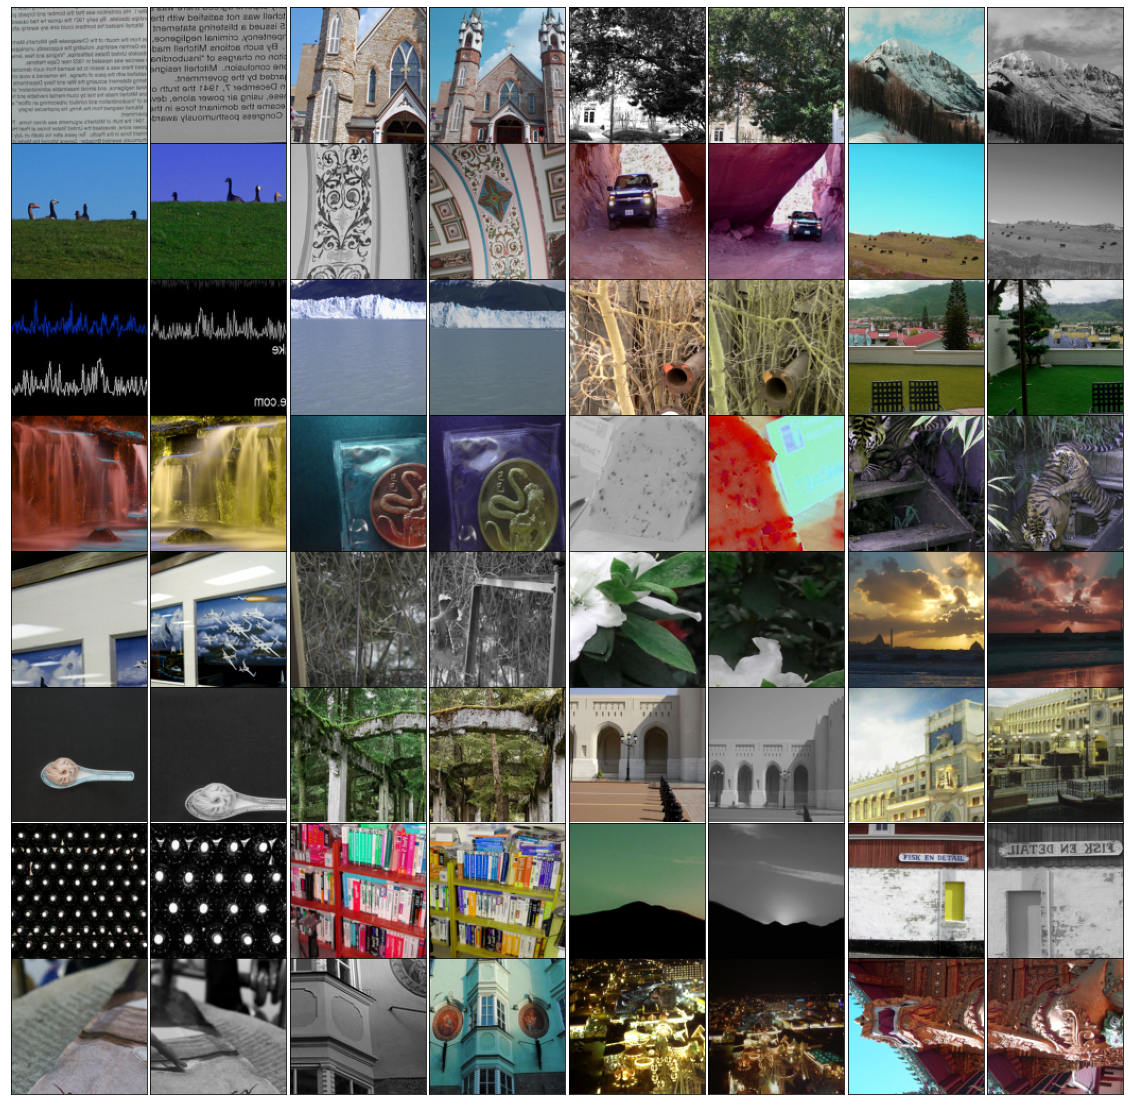

In [8]:
train_dataset = conf.dataset_fn((conf.data_path, args),conf)
train_dataset.visualize_batch()

### Create the training dataloader

In [9]:
# create the data loader
train_loader = DataLoader(train_dataset, batch_size=conf.batch_size,num_workers=conf.workers,pin_memory=True,shuffle=True)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d', len(train_loader.sampler))
msglogger.info('Augmentations:%s',train_loader.dataset.transform)

Dataset sizes:
	training=300000
Augmentations:Compose(
    RandomResizedCrop(size=(128, 128), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    ColorJitter(brightness=(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=(-0.1, 0.1))
    RandomGrayscale(p=0.25)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


### Set up the device, cuda or cpu

In [10]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


### Set up the model for training
* the only line that needs to be changed is ```model = ClassifierBackbone()``` if you have your own model that you want to define

In [11]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = ClassifierBackbone() # edit this to your model class
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input, ), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

model: ClassifierBackbone(
  (conv1): FusedConv2dReLU(
    (activate): ReLU(inplace=True)
    (op): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (clamp_pool): Empty()
  )
  (conv2): FusedConv2dReLU(
    (activate): ReLU(inplace=True)
    (op): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (

Configuring device: MAX78000, simulate=False.


Number of Model Params: 287560


### Set up optimizer, loss, and learning schedule
* nothing needs to be changed

In [12]:
# self-supervised loss
class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, device,temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
        self.negatives_mask = self.negatives_mask.to(device)
        self.temperature = self.temperature.to(device)
        self.device = device
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        batch_size = self.batch_size
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
        self.negatives_mask = self.negatives_mask.to(self.device)
        if emb_i.size()[0] != self.batch_size:
            batch_size = emb_i.size()[0]
            self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            self.negatives_mask = self.negatives_mask.to(self.device)

        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, batch_size)
        sim_ji = torch.diag(similarity_matrix, -batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)
    
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * batch_size)
        # print("CL: ",loss)
        return loss


# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[15, 35,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = ContrastiveLoss(conf.batch_size,conf.device,0.5).to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({15: 1, 35: 1, 100: 1}) gamma: 0.5


### Define the forward function
* this generalizes the way we do a forward pass so we can reuse the training/validation/test functions for different models
* no need to change this

In [13]:
def SSL_forward(model, batch, conf):
    # get the batch items and send to GPU
    input1, input2 = batch[0].to(conf.device), batch[1].to(conf.device)

    # get the output
    return model(input1), model(input2)

conf.forward = SSL_forward

### Train the model
* define the [train function](#helper-functions) if you haven't already
* monitor with tensorboard ```tensorboard --logdir='./jupyer_logging```
    * if using a remote machine, use the ```--port 0``` option

In [ ]:
train(train_loader, None, model,conf)

## **3.2 Train Model on ASL dataset**  
In this step we will start training on the dataset used for the desired task. For this tutorial that will be the ASL dataset for sign language classification.

* If you did pretraining or plan to use the pretrained model then this step will be fine-tuning
    * If you defined your own architecture then you will need to define a second architecture for classification that loads the pretrained weights. Refer to ```ASLClassifier``` in ```classification_models.py``` as a reference
* If you want to train from scratch, then you will need to define your own model in ```classification_models.py```. Feel free to use the ```ClassifierBackbone``` architecture with an extra layer for classification.

---

### Downloading the Source Dataset
The dataset is publicly available on kaggle at [this link](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). 
* Install it into the same ```../../Datasets/``` folder from before. I have placed it into ```../../Datasets/asl/source/``` since this is the **source dataset**
* Next we need to split this dataset into *train* and *test* subsets. A python script called ```dataset_split.py``` has been provided for this. Move it to the ```../../Datasets/``` folder. At the bottom of the script specify the path to the dataset and the relative test-train split you want
* When you run this script it will create a train and test folder within the ```../../Datasets/asl/source/``` directory and leave the original dataset as is in case you need it or want a different split later.
* This dataset contains 29 classes. Since you will need to collect your own data, feel free to only use a subset (e.g. 5-10 classes) to avoid needing to collect 29 classes of data.


### Collecting a Target Dataset
For this step you will need to use the [CamerIF example](https://github.com/MaximIntegratedAI/MAX78000_SDK/tree/11469d1604483525e93d329d008796d7a2c08189/Examples/MAX78000/CameraIF) to save data from the MAX78000 camera. Follow the instructions in the ```pc_utility``` README.md. For conveniance I have provided the .elf for the EV_kit and the needed python scripts in ```./data_collection```.
* I have altered the ```grab_image.py``` script to save each captured image with a unique file name to the desired destination directory (e.g. class1/img0.png). Alter the directory name (```dest_dir``` variable) in the script so images will save based on the class you are collecting data for.

Once you have this application setup and running, collect 10-20 images per class (refer to the kaggle dataset for the classes). I recommend collecting at least 16 images per class so that you can have an 8-4-4 training-validation-test split per class. Once the dataset is collected, move it into ```../../Datasets/asl/target``` and run the ```dataset_split.py``` script with the desired train-test split.
* For conveniance I have also supplied some data I collected if you can't get the data collection working. However, it will work much better if you collect your own data.

### 0.**Setup** Training

***Don't forget to define the training functions and import the needed modules*** (section 2.1)

#### Define Training Configurations
Feel free to modify the hyperparameters. A few tips for training are below.

* Once you find a set of potentially good hyperparameters, fix them and find the average validation accuracy over multiple runs (similar to k-fold) to see if you get consistent performance on several validation splits.
* By default a random validation split is selected each time unless ```deterministic = false```
* I have provided a way to fix the random seed (by default ```aug_seeed = None```) for data augmentation as well since certain augmentations may result in better validation accuracy. During exploration, the augmentation random seed will be logged each time so you can fix it once you find a good configuration to evaluate your hyperparameters.
* Only evaluate on the test set once you are finished tuning the model parameters. The results on the test set are the most meaningful this way.  
* In general strive for > 90% average validation accuracy (depending on the application requirements) because accuracy on this 'clean' source dataset is an upper bound in some sense on accuracy for target dataset. For this specific dataset you should get 99%.

In [6]:
class Config:
    def __init__(self):
        self.dataset_name = "asl" # optional to change
        self.dataset_fn = asl_get_datasets # see this function to change augmentations
        self.num_classes = 29 # change this if using a subset of the classes
        self.model_name = "aslclassifier" # optional to change
        self.dimensions = (3,128,128) # set to model input dimensions
        self.workers = 4 # optional to change
        self.batch_size = 64 # optional to change
        self.validation_split = 0.1 # optional to change
        self.log_prefix = "finetune_asl_base_ev1" # optional to change
        self.log_dir = "jupyter_logging"
        self.data_path = "../../Datasets/asl/source/" # set to dataset location
        self.deterministic = False # only set this if want to be able to replicate trianing exactly
        self.aug_seed = None # fix this once you want to evaluate hyperparameters
        self.print_freq = 200
        # change this to the subset of labels you want to use
        self.labels = ('A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space')
        self.lr = 0.001 # optional to change
        self.num_epochs = 12 # optional to change
        self.qat_policy = {'start_epoch':4, 'weight_bits':8} # optional to change
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.is_classification = True
        self.start_epoch = 0

conf = Config()

#### Set up the logger

In [7]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/DA_ai8x-training/DA_tutorial/jupyter_logging/finetune_asl_base_ev1___2022.08.04-142735/finetune_asl_base_ev1___2022.08.04-142735.log
dataset_name:asl
dataset_fn=<function asl_get_datasets at 0x7f46fe826d30>
num_classes=29
model_name=aslclassifier
dimensions=(3, 128, 128)
batch_size=64
validation_split=0.1
lr=0.001000
num_epochs=12
qat_policy={'start_epoch': 4, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



#### Create the training, validation, and test datasets and dataloaders

Dataset sizes:
	training=70470
	validation=7830
	test=8700
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    ColorJitter(brightness=(0.85, 1.15), contrast=(0.75, 1.25), saturation=(0.75, 1.25), hue=(-0.4, 0.4))
    RandomGrayscale(p=0.15)
    RandomAffine(degrees=[-5.0, 5.0], translate=(0.1, 0.1))
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.5))
    ToTensor()
)
Augmentation Seed:1550770206


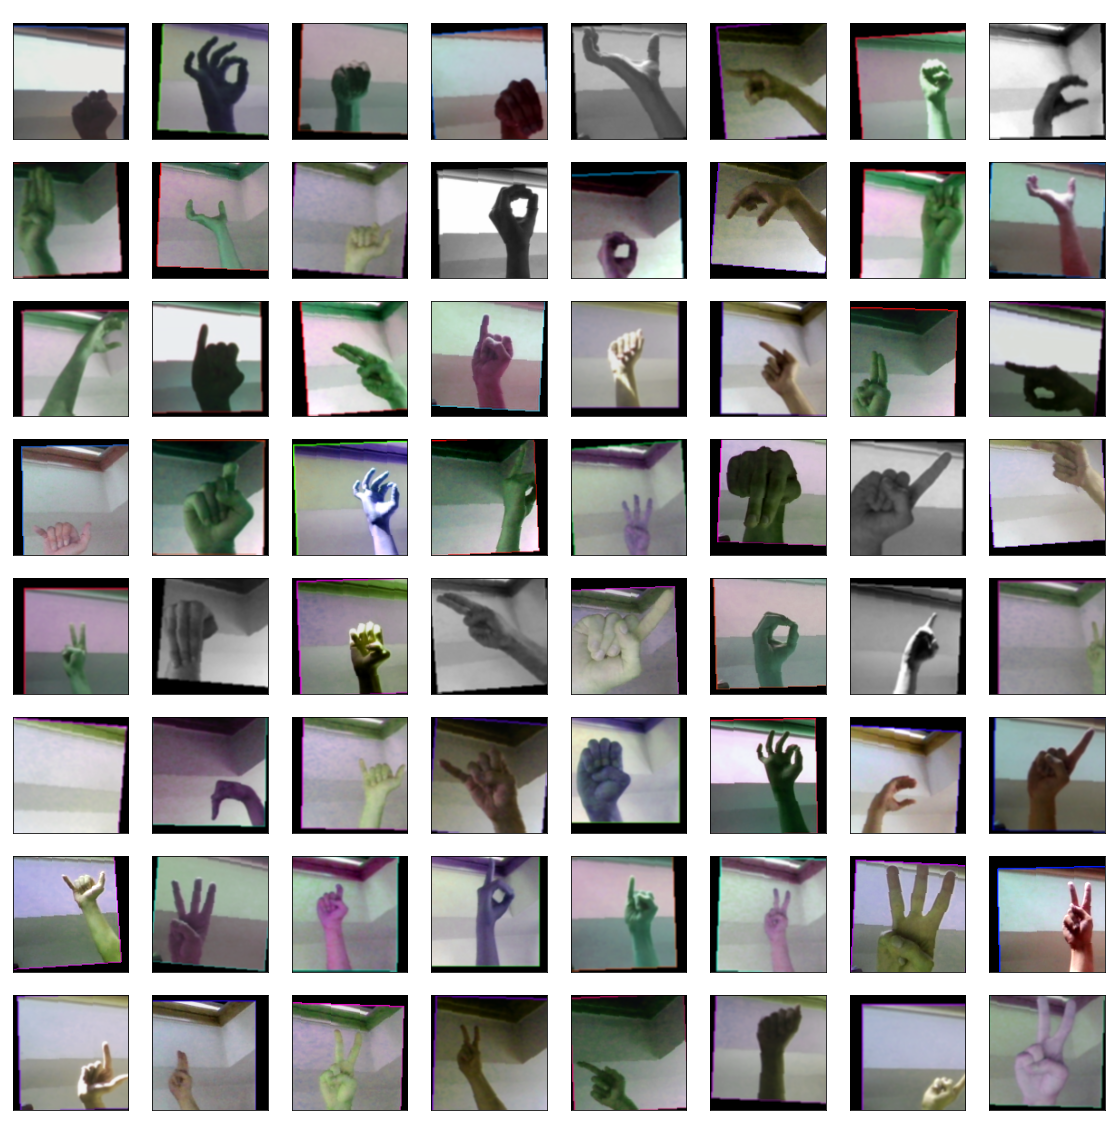

In [8]:
if conf.deterministic:
    worker_init_fn = set_deterministic_settings()
else:
    worker_init_fn = None

# load the train and test sets
train_dataset, val_dataset, test_dataset, aug_seed = conf.dataset_fn((conf.data_path, args), conf, load_train=True, load_val=True, load_test=True)

train_dataset.visualize_batch()


train_loader = DataLoader(train_dataset, batch_size=conf.batch_size,num_workers=conf.workers, pin_memory=True,worker_init_fn=worker_init_fn,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=conf.batch_size,num_workers=conf.workers, pin_memory=True,worker_init_fn=worker_init_fn,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=conf.batch_size,num_workers=conf.workers, pin_memory=True, worker_init_fn=worker_init_fn,shuffle=True)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s\nAugmentation Seed:%s',train_loader.dataset.transform,aug_seed)

#### Set up the device

In [9]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


#### Set up the model
* only line that needs to be changed is the model class if you are using a different architecture

In [10]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = ASLClassifier() # set the model
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input, ), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

Configuring device: MAX78000, simulate=False.


Number of Model Params: 288773


#### Set up the optimizer and loss
* change the learning rate schedule if you want

In [11]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[4,8, 20,100], gamma=0.75)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = nn.CrossEntropyLoss().to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({4: 1, 8: 1, 20: 1, 100: 1}) gamma: 0.75


#### Define the forward function

In [12]:
def classifier_forward(model, batch, conf):
    # get the batch items and send to GPU
    inputs, target, path = batch[0].to(conf.device), batch[1].to(conf.device), batch[2]

    # get the output
    return model(inputs), target

conf.forward = classifier_forward

### 1.**Train** the model
* monitor with tensorboard ```tensorboard --logdir='./jupyer_logging```
    * if using a remote machine, use the ```--port 0``` option

In [13]:
train(train_loader, val_loader, model,conf)

Training epoch: 70470 samples (64 per mini-batch)
Epoch: [0][  200/ 1102]    objective_loss 3.315153                                        LR 0.001000    
Epoch: [0][  400/ 1102]    objective_loss 3.029361                                        LR 0.001000    
Epoch: [0][  600/ 1102]    objective_loss 2.731041                                        LR 0.001000    
Epoch: [0][  800/ 1102]    objective_loss 2.456729                                        LR 0.001000    
Epoch: [0][ 1000/ 1102]    objective_loss 2.224454                                        LR 0.001000    
Epoch: [0][ 1102/ 1102]    objective_loss 2.123399    Top1 70.000000    Top5 95.714286    LR 0.001000    
--- validate (epoch=0)-----------
7830 samples (64 per mini-batch)
Epoch: [0][  123/  123]    Loss 0.716433    Top1 77.049808    Top5 99.450830    
==> Top1: 77.050    Top5: 99.451    Loss: 0.716

==> Confusion:
[[203  26   0   0  28   0   0   0   0   1   0   0   8   1   0   0   0   0
    1   0   0   0   0   0   

QAT is starting!


Epoch: [4][  200/ 1102]    objective_loss 0.961188                                        LR 0.000750    
Epoch: [4][  400/ 1102]    objective_loss 0.849289                                        LR 0.000750    
Epoch: [4][  600/ 1102]    objective_loss 0.772746                                        LR 0.000750    
Epoch: [4][  800/ 1102]    objective_loss 0.714281                                        LR 0.000750    
Epoch: [4][ 1000/ 1102]    objective_loss 0.789319                                        LR 0.000750    
Epoch: [4][ 1102/ 1102]    objective_loss 0.819666    Top1 94.285714    Top5 100.000000    LR 0.000750    
--- validate (epoch=4)-----------
7830 samples (64 per mini-batch)
Epoch: [4][  123/  123]    Loss 0.896755    Top1 96.819923    Top5 99.987229    
==> Top1: 96.820    Top5: 99.987    Loss: 0.897

==> Confusion:
[[271   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0 272   0   0   0   0   0 

### 2.**Test** the final model on the **source** test set
* copy the relative path to the trained model and test the model
* if you fine-tune hyperparameters and evaluate on the test set again, you might be overfitting the test set so use the validation accuracy to tune the hyperparameters

In [14]:
model = ASLClassifier()
model_path = "jupyter_logging/finetune_asl_base_ev1___2022.08.04-142735/aslclassifier_qat_best.pth.tar"
test(test_loader, model, model_path, [pylogger], conf)

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

Configuring device: MAX78000, simulate=False.


Test: [  136/  136]    Loss 0.370772    Top1 99.482759    Top5 100.000000    
==> Top1: 99.483    Top5: 100.000    Loss: 0.371

==> Confusion:
[[299   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0 300   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 300   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 300   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 300   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 299   0   0   0   0   0   0   0   0   1   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 300   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 

### 3.**Test** this model on the **target** test set
* You should see a huge drop in accuracy compared to the source test set

In [15]:
# load the train and test sets
_, _, test_dataset, _ = conf.dataset_fn(("../../Datasets/asl/target/", args), conf, load_train=False, load_val=False, load_test=True)

test_loader = DataLoader(test_dataset, batch_size=32,num_workers=4, pin_memory=True)

model = ASLClassifier()
model_path = "jupyter_logging/finetune_asl_base_ev1___2022.08.04-142735/aslclassifier_qat_best.pth.tar"
test(test_loader, model, model_path, [pylogger], conf)

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

Configuring device: MAX78000, simulate=False.


Test: [    6/    6]    Loss 1.291169    Top1 67.187500    Top5 88.541667    
==> Top1: 64.198    Top5: 88.889    Loss: 1.409

==> Confusion:
[[ 4  0  0  0  0  1  0  0  1  0  0  1  1  1  0  0  0  0  0  1  0  0  1  0
   1  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0  0  0  2  2  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  1  3  0  0  0  0  0  0  0  0  2
   0  0  4  0  0]
 [ 0  0  0  7  0  0  0  0  6  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 5  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10

### 4.Visualize **Embeddings**  
#### Visualize asl clusters from dataset and from camera  
* set the test_batch_path to ../../Datasets/asl/
* then set the domain to either 0 (source), 1 (target), or 2 (both)
* if you set to source or target, the accuracy over a random batch (from the test set) will be printed and t-sne embeddings will be published for that batch
* if you set to both, no accuracy will be printed but embeddings for both source and target will be published which is useful for visualizing the domain shift. For this particular dataset there are so many classes that it is hard to visualize so I only look at a subset of 6 classes. If you want to visualize this, copy 6 classes to a subset folder from the source and target test sets so that you have ```asl/subset/source/test/``` and ```asl/subset/target/test/```

We see that for the source test batch of images we get a high accuracy and for the target test batch of images we get around a low accuracy. When visualizing the output embeddings of the CNN encoder we also see that the source images clusters better. However, it is important to note that the target images still cluster but these clusters become *shifted* from the source clusters.

In [16]:
# init the model
model = ASLClassifier()

# create the embeddings
viz_embeddings("../../Datasets/asl/subset/",conf,128,"jupyter_logging/finetune_asl_base_ev1___2022.08.04-142735/aslclassifier_qat_best.pth.tar",\
               model,2,True)

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

Configuring device: MAX78000, simulate=False.
['E_SRC', 'del_SRC', 'del_SRC', 'B_SRC', 'C_SRC', 'B_SRC', 'E_SRC', 'C_SRC', 'C_SRC', 'D_SRC', 'E_SRC', 'C_SRC', 'del_SRC', 'B_SRC', 'D_SRC', 'C_SRC', 'A_SRC', 'D_SRC', 'del_SRC', 'E_SRC', 'D_SRC', 'del_SRC', 'B_SRC', 'D_SRC', 'A_SRC', 'A_SRC', 'E_SRC', 'D_SRC', 'D_SRC', 'del_SRC', 'E_SRC', 'C_SRC', 'A_SRC', 'D_SRC', 'B_SRC', 'del_SRC', 'del_SRC', 'del_SRC', 'D_SRC', 'A_SRC', 'B_SRC', 'del_SRC', 'A_SRC', 'E_SRC', 'del_SRC', 'C_SRC', 'D_SRC', 'B_SRC', 'del_SRC', 'B_SRC', 'del_SRC', 'A_SRC', 'A_SRC', 'C_SRC', 'C_SRC', 'E_SRC', 'B_SRC', 'C_SRC', 'B_SRC', 'E_SRC', 'D_SRC', 'B_SRC', 'C_SRC', 'D_SRC', 'C_SRC', 'B_SRC', 'D_SRC', 'D_SRC', 'A_SRC', 'D_SRC', 'del_SRC', 'del_SRC', 'del_SRC', 'C_SRC', 'E_SRC', 'A_SRC', 'del_SRC', 'C_SRC', 'del_SRC', 'del_SRC', 'A_SRC', 'D_SRC', 'C_SRC', 'C_SRC', 'B_SRC', 'A_SRC', 'A_SRC', 'D_SRC', 'B_SRC', 'D_SRC', 'B_SRC', 'del_SRC', 'D_SRC', 'del_SRC', 'del_SRC', 'A_SRC', 'del_SRC', 'D_SRC', 'A_SRC', 'A_SRC', 'E_SRC'

Ideally you should see something like this when visualizing the t-SNE embeddings. We see that individual letters cluster well but the source and target domain classes have shifted. The goal is that the clusters of the same class should overlap.

<center>

![clusters](images/cluster.png)

</center>


## **3.3 Now let's do domain adaptation**
The goal here is to shift the clusters so that the same classes overlap from the source and target domain. This process has two stage which are described below.

---

### **How the FADA Method Works** (optional)

#### **Stage 1**: Train a discriminator
* In this stage we want to train a *discriminator* that can distinguish between images from the source domain and target domain. We do this by generating image pairs using the following convention:
    * Class G1 --> same class, source domain
    * Class G2 --> same class, different domain
    * Class G3 --> different class, source domain
    * Class G4 --> different class, different domain

<center>

![classes](images/disc.png)

</center>

We freeze the *encoder* portion of the original model (dotted line) and train new output layers to classify these 4 types of image pairs (pairs of images enables us to generate many samples with few target samples) as shown by this diagram from the original paper

<center>

![disc model](images/disc_model.svg)

</center>

#### **Stage 2**: Do Adverserial Training to trick the discriminator
* In this stage we want to train the encoder part of the model to trick the discriminator part of the model while still maintaining good accuracy. We do this by training in an adverserial manner. See the original paper for more details. From a high level we want a CNN that generates features that are good for image classification, but at the same time the features should be *domain-invariant*. This means that the features should be the same *similar* for images of the same class regardless of the domain. As shown below, we freeze the domain-class discriminator and train the encoder and evaluate on classification and adversarial losses.

<center>

![adv model](images/adv.svg)

</center>

##### Validation Selection
Since we have image pairs as samples, selecting a validation set becomes more involved and we have two choices
* **constrained validation**: here we generate many images pairs and then select a subset to be the validation set. The issue here is that while the validation pairs will be unique from the training pairs, individual images can appear in both training and validation since each image can be used to generate multiple pairs. Use constrained validation if 'k' is small for the target (e.g. only one or two images per class). This produces inflated validation accuracy since there is data leakage.
* **normal validation**: here we first split the source and target data into validation sets. Then when generating the validation pairs, we only sample from the source and target validation sets. This way all pairs and images in the validation set are unique from the training set (no data leakage). This however requires a larger 'k' for the target set (at least three). The validation set is selected using 0.33*k so if we have k = 6, 2 images per class will be reserved for validation

* If you have at least 6 images per class for the target training set, select normal validation (```constrained_validation = False```)

### First train the **discriminator**

#### 0.**Setup** Training

##### New Training Parameters for discriminator

In [33]:
class Config:
    def __init__(self):
        self.dataset_name = "pairs"
        self.dataset_fn = pairs_get_datasets
        self.num_classes = 4
        self.model_name = "asldcdnet"
        self.dimensions = (1,128)
        self.workers = 4
        self.batch_size = 64
        self.log_prefix = "asl_dcd_train_k8"
        self.log_dir = "jupyter_logging"
        self.source_data_path = "../../Datasets/asl/source/"
        self.target_data_path = "../../Datasets/asl/target/"
        self.deterministic = False
        self.print_freq = 100
        self.labels = ('G1', 'G2', 'G3', 'G4')
        self.lr = 0.002
        self.num_epochs = 10
        self.qat_policy = {'start_epoch':1, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.enc_model = None
        self.enc_output = None
        self.is_classification = True
        self.start_epoch = 0
        self.constrained_validation = False # for the normal validation the split will be .66-.33
        self.validation_split = 0.1
        self.k = 8

conf = Config()

##### Set up the logger

In [34]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/DA_ai8x-training/DA_tutorial/jupyter_logging/asl_dcd_train_k8___2022.08.04-150340/asl_dcd_train_k8___2022.08.04-150340.log
dataset_name:pairs
dataset_fn=<function pairs_get_datasets at 0x7f4700ae7d30>
num_classes=4
model_name=asldcdnet
dimensions=(1, 128)
batch_size=64
validation_split=0.1
lr=0.002000
num_epochs=10
qat_policy={'start_epoch': 1, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



##### Create and Visualize the dataset
* Class G1 --> same class, source domain
* Class G2 --> same class, different domain
* Class G3 --> different class, source domain
* Class G4 --> different class, different domain
* the first label is the pair label, the parentheses label is the class label

Max possible pairs: G1 =  105665850  G2 =  626400  G3 =  3065405850  G4 =  17539200
Max possible pairs: G1 =  46963241  G2 =  313200  G3 =  1362393900  G4 =  8769600
Max possible pairs: G1 =  11741291  G2 =  52200  G3 =  340591950  G4 =  1461600


Dataset sizes:
	training=83520
	validation=13920
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    ToTensor()
)



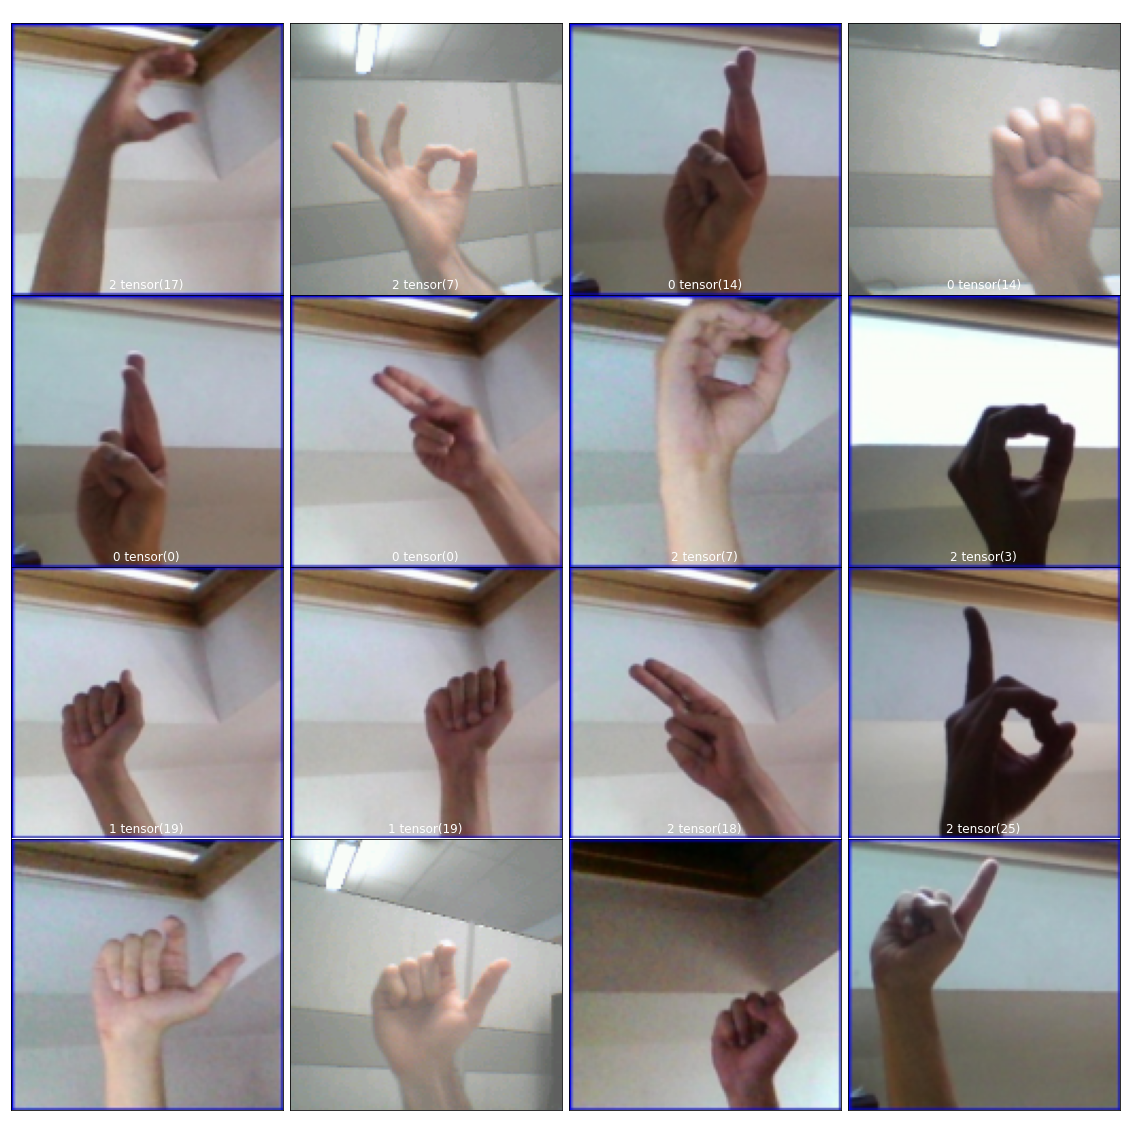

In [35]:
if conf.deterministic:
    worker_init_fn = set_deterministic_settings()
else:
    worker_init_fn = None

# load the train and test sets
train_dataset, val_dataset = conf.dataset_fn(((conf.source_data_path,conf.target_data_path), args), conf,pair_factor=15)

train_dataset.visualize_batch()

train_loader = DataLoader(train_dataset, batch_size=conf.batch_size,num_workers=conf.workers, pin_memory=True,worker_init_fn=worker_init_fn,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=conf.batch_size,num_workers=conf.workers, pin_memory=True,worker_init_fn=worker_init_fn,shuffle=True)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d', len(train_loader.sampler), len(val_loader.sampler))
msglogger.info('Augmentations:%s\n',train_loader.dataset.transform)

##### Set up the device

In [36]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


##### Set up the model

In [37]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = ASLDCD()
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input1 = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input1,), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

model: ASLDCD(
  (fc1): FusedLinearReLU(
    (activate): ReLU(inplace=True)
    (op): Linear(in_features=128, out_features=64, bias=True)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (clamp_pool): Empty()
  )
  (fc2): Linear(
    (activate): Empty()
    (op): Linear(in_features=64, out_features=4, bias=True)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (clamp_pool): Empty()
  )
  (do): Dropout(p=0.2, inplace=False)
)
Number of Model Param

Configuring device: MAX78000, simulate=False.


##### Optimizer, Loss

In [38]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[4,8, 35,100], gamma=0.2)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = torch.nn.CrossEntropyLoss().to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.002] milestones: Counter({4: 1, 8: 1, 35: 1, 100: 1}) gamma: 0.2


##### Define the forward function

In [39]:
# load the encoder-classifier model
load_model_path = "jupyter_logging/finetune_asl_base_ev1___2022.08.04-142735/aslclassifier_qat_best.pth.tar"
enc_model = ASLClassifier()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(enc_model)
enc_model = apputils.load_lean_checkpoint(enc_model, load_model_path, model_device=conf.device)
ai8x.update_model(enc_model)
enc_model = enc_model.to(conf.device)

# register a forward hook to get the encoder output
conf.enc_output = {}
def get_embedding(name):
    def hook(model, input, output):
        conf.enc_output[name] = output.detach()
    return hook

# get the activations
enc_model.feature_extractor.fc2.register_forward_hook(get_embedding('fc2'))
conf.enc_model = enc_model

def cd_DCD_forward(model, batch, conf):
    inputs1, inputs2, target, img1_label, imgs2_label = batch[0].to(conf.device), batch[1].to(conf.device), batch[2].to(conf.device), batch[3].to(conf.device), batch[4].to(conf.device)

    # encoder output for sample 1
    out1 = conf.enc_model(inputs1)
    enc1 = conf.enc_output['fc2']

    # encoder output for sample 2
    out2 = conf.enc_model(inputs2)
    enc2 = conf.enc_output['fc2']

    # concatenate and pass through DCD
    X_cat = torch.cat([enc1,enc2],1)
    return model(X_cat.detach()), target

conf.forward = cd_DCD_forward

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

#### 1.**Train**

In [40]:
train(train_loader, val_loader, model,conf)

Training epoch: 83520 samples (64 per mini-batch)
Epoch: [0][  100/ 1305]    objective_loss 1.231952                                        LR 0.002000    
Epoch: [0][  200/ 1305]    objective_loss 1.093780                                        LR 0.002000    
Epoch: [0][  300/ 1305]    objective_loss 1.007530                                        LR 0.002000    
Epoch: [0][  400/ 1305]    objective_loss 0.952209                                        LR 0.002000    
Epoch: [0][  500/ 1305]    objective_loss 0.910612                                        LR 0.002000    
Epoch: [0][  600/ 1305]    objective_loss 0.877853                                        LR 0.002000    
Epoch: [0][  700/ 1305]    objective_loss 0.852154                                        LR 0.002000    
Epoch: [0][  800/ 1305]    objective_loss 0.832376                                        LR 0.002000    
Epoch: [0][  900/ 1305]    objective_loss 0.815068                                        LR 0.002000 

QAT is starting!


Epoch: [1][  100/ 1305]    objective_loss 0.898359                                        LR 0.002000    
Epoch: [1][  200/ 1305]    objective_loss 0.871057                                        LR 0.002000    
Epoch: [1][  300/ 1305]    objective_loss 0.864489                                        LR 0.002000    
Epoch: [1][  400/ 1305]    objective_loss 0.892352                                        LR 0.002000    
Epoch: [1][  500/ 1305]    objective_loss 0.902229                                        LR 0.002000    
Epoch: [1][  600/ 1305]    objective_loss 0.905204                                        LR 0.002000    
Epoch: [1][  700/ 1305]    objective_loss 0.904631                                        LR 0.002000    
Epoch: [1][  800/ 1305]    objective_loss 0.901550                                        LR 0.002000    
Epoch: [1][  900/ 1305]    objective_loss 0.897019                                        LR 0.002000    
Epoch: [1][ 1000/ 1305]    objective_loss 0.89

### Now do **adversarial** training to trick the discriminator

#### 0.**Setup** Training

##### Training Configuration for both models

In [52]:
class Config:
    def __init__(self):
        self.dataset_name = "pairs"
        self.dataset_fn = pairs_get_datasets
        self.num_classes = 4
        self.model_name = "asldcdnet"
        self.dimensions = (1,128)
        self.workers = 4
        self.batch_size = 64
        self.log_prefix = "asl_dcd_train_adv_k8"
        self.log_dir = "jupyter_logging"
        self.source_data_path = "../../Datasets/asl/source/"
        self.target_data_path = "../../Datasets/asl/target/"
        self.deterministic = False
        self.print_freq = 32
        self.labels = ('G1', 'G2', 'G3', 'G4')
        self.lr = 0.001
        self.num_epochs = 8
        self.qat_policy = {'start_epoch':4, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.adv_criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.enc_model = None
        self.enc_output = None
        self.dcd_model = None
        self.constrained_validation = False # for the normal validation the split will be .66-.33
        self.validation_split = 0.1
        self.k = 8
        self.classifier_forward = None

conf_c = Config()
conf_c.lr = 0.001
conf_c.num_classes = 29
conf_c.labels = ('A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space')
conf_c.model_name = "aslclassifier"
conf_c.dimensions = (3,128,128)
conf_c.batch_size = 32
conf_c.dataset_fn = pairs_get_datasets_c
conf_d = Config()

##### Logger

In [53]:
msglogger = apputils.config_pylogger('logging.conf', conf_c.log_prefix, conf_c.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf_c.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf_c.dataset_name,conf_c.dataset_fn,conf_c.num_classes,conf_c.model_name,conf_c.dimensions,conf_c.batch_size,conf_c.validation_split,conf_c.lr,conf_c.num_epochs,conf_c.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/DA_ai8x-training/DA_tutorial/jupyter_logging/asl_dcd_train_adv_k8___2022.08.04-152648/asl_dcd_train_adv_k8___2022.08.04-152648.log
dataset_name:pairs
dataset_fn=<function pairs_get_datasets_c at 0x7f46fe826b80>
num_classes=29
model_name=aslclassifier
dimensions=(3, 128, 128)
batch_size=32
validation_split=0.1
lr=0.001000
num_epochs=8
qat_policy={'start_epoch': 4, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



##### Create the dataloaders

Max possible pairs: G1 =  105665850  G2 =  626400  G3 =  3065405850  G4 =  17539200
Max possible pairs: G1 =  46962058  G2 =  313200  G3 =  1362393900  G4 =  8769600
Max possible pairs: G1 =  105665850  G2 =  626400  G3 =  3065405850  G4 =  17539200
Max possible pairs: G1 =  46965617  G2 =  313200  G3 =  1362393900  G4 =  8769600
Max possible pairs: G1 =  11743667  G2 =  52200  G3 =  340591950  G4 =  1461600


Dataset sizes:
	training=41760
	validation=81
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    ToTensor()
)



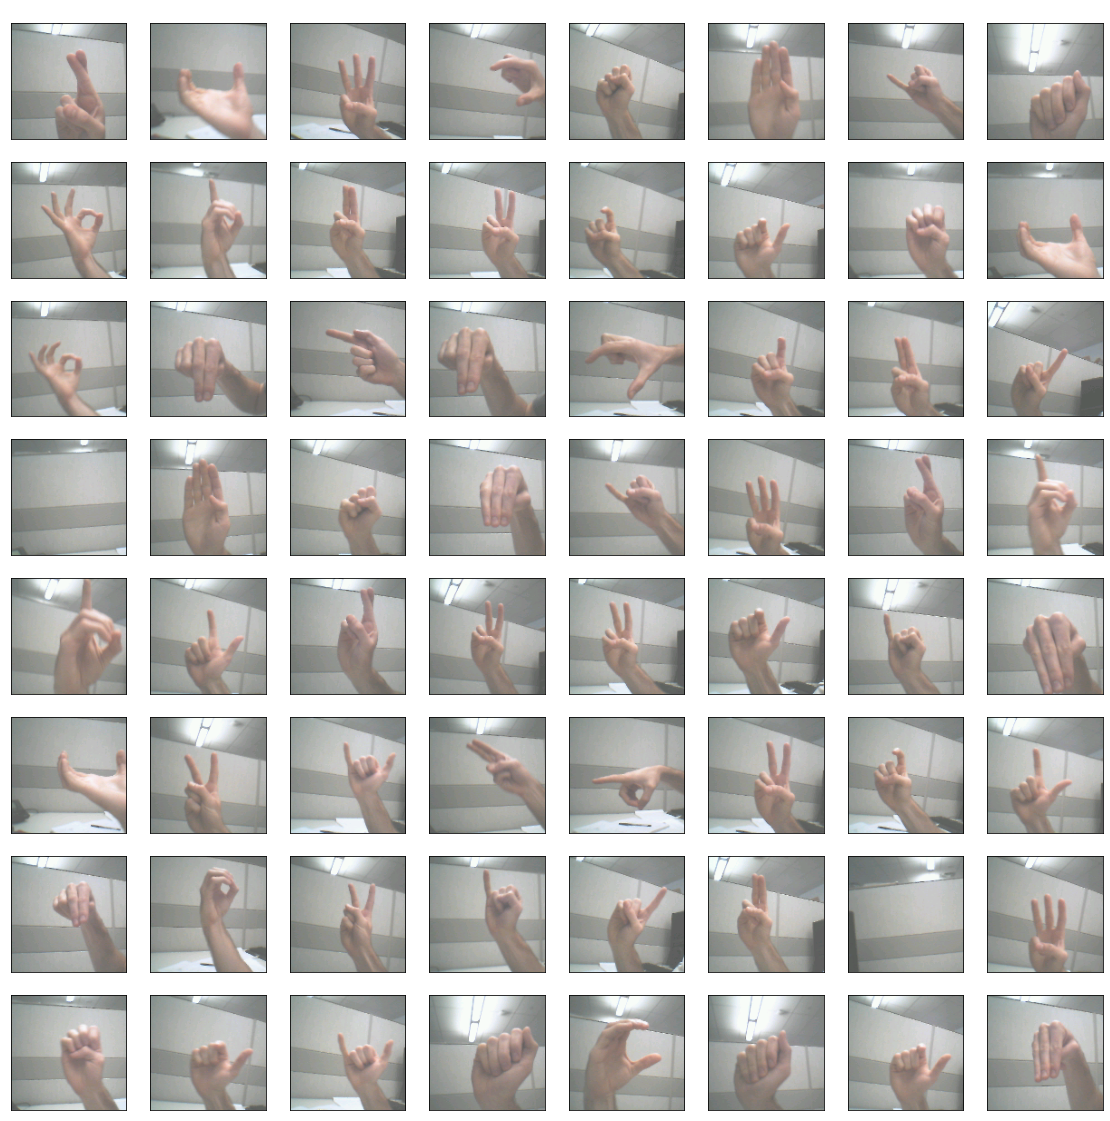

In [54]:
if conf_c.deterministic:
    worker_init_fn = set_deterministic_settings()
else:
    worker_init_fn = None

# load the train and test sets
train_dataset_c, val_dataset_c = conf_c.dataset_fn(((conf_c.source_data_path,conf_c.target_data_path), args), conf_c,pair_factor=15)
train_dataset_d, val_dataset_d = conf_d.dataset_fn(((conf_d.source_data_path,conf_d.target_data_path), args), conf_d,pair_factor=15)

val_dataset_c.visualize_batch()

train_loader_c = DataLoader(train_dataset_c, batch_size=conf_c.batch_size,num_workers=conf_c.workers, pin_memory=True,worker_init_fn=worker_init_fn,shuffle=True)
val_loader_c = DataLoader(val_dataset_c, batch_size=conf_c.batch_size,num_workers=conf_c.workers, pin_memory=True,worker_init_fn=worker_init_fn,shuffle=True)

train_loader_d= DataLoader(train_dataset_d, batch_size=conf_d.batch_size,num_workers=conf_d.workers, pin_memory=True,worker_init_fn=worker_init_fn,shuffle=True)
val_loader_d = DataLoader(val_dataset_d, batch_size=conf_d.batch_size,num_workers=conf_d.workers, pin_memory=True,worker_init_fn=worker_init_fn,shuffle=True)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d', len(train_loader_c.sampler), len(val_loader_c.sampler))
msglogger.info('Augmentations:%s\n',train_loader_c.dataset.transform)

##### set up the device

In [55]:
conf_c.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
conf_d.device = conf_c.device
print('Running on device: {}'.format(conf_c.device))

Running on device: cuda:0


##### Setup the models

In [56]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the classifier model
load_model_path = "jupyter_logging/finetune_asl_base_ev1___2022.08.04-142735/aslclassifier_qat_best.pth.tar"
enc_model = ASLClassifier()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(enc_model)
enc_model = apputils.load_lean_checkpoint(enc_model, load_model_path, model_device=conf_c.device)
ai8x.update_model(enc_model)
enc_model = enc_model.to(conf_c.device)

# create the DCD model
load_model_path = "jupyter_logging/asl_dcd_train_k8___2022.08.04-150340/asldcdnet_qat_best.pth.tar"
dcd_model = ASLDCD()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(dcd_model)
dcd_model = apputils.load_lean_checkpoint(dcd_model, load_model_path, model_device=conf_c.device)
ai8x.update_model(dcd_model)
dcd_model = dcd_model.to(conf_c.device)

# configure tensorboard
dummy_input1 = torch.randn((1, ) + conf_c.dimensions)
tflogger.tblogger.writer.add_graph(enc_model.to('cpu'), (dummy_input1,), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

Configuring device: MAX78000, simulate=False.


##### Loss and optimizer

In [57]:
# optimizer
conf_c.optimizer = optim.Adam(enc_model.parameters(), lr=conf_c.lr)
msglogger.info('Optimizer Type: %s', type(conf_c.optimizer))

conf_d.optimizer = optim.Adam(dcd_model.parameters(), lr=conf_c.lr)
msglogger.info('Optimizer Type: %s', type(conf_d.optimizer))

# lr schedule
conf_c.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf_c.optimizer, milestones=[4, 20,100], gamma=0.5)
conf_d.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf_d.optimizer, milestones=[4, 20,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf_c.lr_scheduler.base_lrs)+" milestones: "+str(conf_c.lr_scheduler.milestones)+ " gamma: "+str(conf_c.lr_scheduler.gamma))

def dcd_adv_loss(output, target):
    g2s = F.log_softmax(output[target == 0])
    g4s = F.log_softmax(output[target == 2])

    term_1 = F.nll_loss(g2s,target[target == 0])
    term_2 = -F.nll_loss(g4s,target[target == 2])
    
    return term_1 + term_2 

# loss function
#conf_c.criterion = torch.nn.CrossEntropyLoss().to(conf_c.device)
conf_c.criterion = torch.nn.CrossEntropyLoss().to(conf_d.device)
conf_c.adv_criterion = dcd_adv_loss
conf_d.criterion = torch.nn.CrossEntropyLoss().to(conf_d.device)
compression_scheduler_c = distiller.CompressionScheduler(enc_model)
compression_scheduler_d = distiller.CompressionScheduler(dcd_model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({4: 1, 20: 1, 100: 1}) gamma: 0.5


##### Forward functions

In [58]:
# register a forward hook to get the encoder output
conf_c.enc_output = {}
def get_embedding(name):
    def hook(model, input, output):
        conf_c.enc_output[name] = output
    return hook

# get the activations
enc_model.feature_extractor.fc2.register_forward_hook(get_embedding('fc2'))
enc_model = enc_model.to(conf_c.device)
conf_c.enc_model = enc_model

conf_d.dcd_model = dcd_model

def cd_DCD_forward(model, batch, conf, conf_c):
    inputs1, inputs2, target, img1_label, imgs2_label = batch[0].to(conf.device), batch[1].to(conf.device), batch[2].to(conf.device), batch[3].to(conf.device), batch[4].to(conf.device)

    # encoder output for sample 1
    out1 = conf_c.enc_model(inputs1)
    enc1 = conf_c.enc_output['fc2']

    # encoder output for sample 2
    out2 = conf_c.enc_model(inputs2)
    enc2 = conf_c.enc_output['fc2']

    # concatenate and pass through DCD
    X_cat = torch.cat([enc1,enc2],1)
    return model(X_cat.detach()), target

def cd_classifier_forward(model, batch, conf, conf_d):
    inputs1, inputs2, target, imgs1_labels, imgs2_labels = batch[0].to(conf.device), batch[1].to(conf.device), batch[2].to(conf.device), batch[3].to(conf.device), batch[4].to(conf.device)

    # encoder output for sample 1
    out1 = conf.enc_model(inputs1)
    enc1 = conf.enc_output['fc2']

    # encoder output for sample 2
    out2 = conf.enc_model(inputs2)
    enc2 = conf.enc_output['fc2']

    # concatenate and pass through DCD
    X_cat = torch.cat([enc1,enc2],1)

    # the dcd output and target as well as the classifier outputs and targets
    return conf_d.dcd_model(X_cat), target, out1, imgs1_labels, out2, imgs2_labels

def classifier_forward(model, batch, conf):
    # get the batch items and send to GPU
    inputs, target, path = batch[0].to(conf.device), batch[1].to(conf.device), batch[2]

    # get the output
    return model(inputs), target

conf_d.forward = cd_DCD_forward
conf_c.forward = cd_classifier_forward
conf_c.classifier_forward = cd_classifier_forward

#### 1.**Train**

##### Define a new validation function for adversarial training
* this is only used if doing constrained validation (very few target images)

In [18]:
def adv_validate(val_loader_c, val_loader_d, classifier_model, conf_c, discriminator_model, conf_d, loggers, epoch=-1, tflogger=-1):
    
    # store loss stats
    enc_losses = {'class_loss': tnt.AverageValueMeter(),'disc_c_loss': tnt.AverageValueMeter()}
    disc_losses = {'disc_d_loss': tnt.AverageValueMeter()}

    classerr_class = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_c.num_classes, 5))) # classification error
    classerr_disc_c = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error classification phase
    classerr_disc_d = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error during dcd phase

    # validation set info
    total_samples = len(val_loader_c.sampler)
    batch_size = val_loader_c.batch_size

    confusion_class = tnt.ConfusionMeter(conf_c.num_classes)
    confusion_disc_c = tnt.ConfusionMeter(conf_d.num_classes)
    confusion_disc_d = tnt.ConfusionMeter(conf_d.num_classes)

    total_steps = (total_samples + conf_c.batch_size - 1) // conf_c.batch_size
    msglogger.info('%d samples (%d per mini-batch)', total_samples, conf_c.batch_size)

    # Switch to evaluation mode
    classifier_model.eval()
    discriminator_model.eval()

    class_probs = []
    class_preds = []
    dcd_c_probs = []
    dcd_c_preds = []
    dcd_d_probs = []
    dcd_d_preds = []

    # iterate over the batches in the validation set
    for validation_step in range(32):
        with torch.no_grad():
            
            batch_c = next(iter(val_loader_c)) # get a single batch
            batch_d = next(iter(val_loader_d))

            # pass the input through the classifier
            dcd_out_c, dcd_target_c, img1_out, img1_target, img2_out, img2_target = conf_c.forward(classifier_model, batch_c, conf_c, conf_d)
            # print("output: ", dcd_out_c)
            # print("target: ", dcd_target_c)

            # pass the input through the dcd
            dcd_out_d, dcd_target_d = conf_d.forward(discriminator_model, batch_d, conf_d, conf_c)
            
            # print(conf_c.device)
            # print(conf_d.device)
            # print("model on gpu:", next(classifier_model.parameters()).is_cuda)
            # print("model on gpu:", next(discriminator_model.parameters()).is_cuda)

            # correct output for accurate loss calculation
            if conf_c.args.act_mode_8bit:
                dcd_out_c /= 128.
                dcd_out_d /= 128.
                img1_out /= 128.
                img2_out /= 128.
                for key in model.__dict__['_modules'].keys():
                    if (hasattr(model.__dict__['_modules'][key], 'wide')
                            and model.__dict__['_modules'][key].wide):
                        dcd_out_c /= 256.
                        dcd_out_d /= 256.
                        img1_out /= 256.
                        img2_out /= 256.
            
            # collect all the losses
            dcd_loss = conf_c.adv_criterion(dcd_out_c, dcd_target_c)
            img1_loss = conf_c.criterion(img1_out, img1_target)
            img2_loss = conf_c.criterion(img2_out, img2_target)
            loss = dcd_loss + img1_loss + img2_loss
            enc_losses['class_loss'].add(img1_loss.item() + img2_loss.item())
            enc_losses['disc_c_loss'].add(dcd_loss.item())

            # collect accuracy stats
            classerr_class.add(img1_out.data, img1_target)
            classerr_class.add(img2_out.data, img2_target)
            classerr_disc_c.add(dcd_out_c.data, dcd_target_c)

            confusion_class.add(img1_out.data, img1_target)
            confusion_class.add(img2_out.data, img2_target)
            confusion_disc_c.add(dcd_out_c.data, dcd_target_c)


            dcd_loss_d = conf_d.criterion(dcd_out_d, dcd_target_d)
            disc_losses['disc_d_loss'].add(dcd_loss_d.item())

            classerr_disc_d.add(dcd_out_d.data, dcd_target_d)
            confusion_disc_d.add(dcd_out_d.data, dcd_target_d)
            

            # store prediction stats
            steps_completed = (validation_step+1)
            if steps_completed % conf_c.print_freq == 0 or steps_completed == total_steps:
                class_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in torch.cat((img1_out,img2_out))]
                dcd_c_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in dcd_out_c]
                dcd_d_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in dcd_out_d]

                _, class_preds_batch = torch.max(torch.cat((img1_out,img2_out)), 1)
                _, dcd_c_preds_batch = torch.max(dcd_out_c, 1)
                _, dcd_d_preds_batch = torch.max(dcd_out_d, 1)

                class_probs.append(class_probs_batch)
                class_preds.append(class_preds_batch)
                dcd_c_probs.append(dcd_c_probs_batch)
                dcd_c_preds.append(dcd_c_preds_batch)
                dcd_d_probs.append(dcd_d_probs_batch)
                dcd_d_preds.append(dcd_d_preds_batch)

                stats = (
                    '',
                    OrderedDict([('Class Loss', enc_losses['class_loss'].mean),
                                 ('disc_c Loss', enc_losses['disc_c_loss'].mean),
                                 ('disc_d Loss', disc_losses['disc_d_loss'].mean),
                                    ('Class Top1', classerr_class.value(1)),
                                    ('disc_c Top1', classerr_disc_c.value(1)),
                                    ('disc_d Top1', classerr_disc_d.value(1))]),
                                    
                )
                if conf_c.num_classes > 5:
                    stats[1]['Top5'] = classerr_class.value(5)

                distiller.log_training_progress(stats, None, epoch, steps_completed,
                                                total_steps, conf_c.print_freq, loggers)


    if conf_c.num_classes > 5:
        msglogger.info('==> Class Top1: %.3f    Class Top5: %.3f    Class Loss: %.3f    DCD_c Top1: %.3f DCD_c Loss: %.3f    DCD_d Top1: %.3f DCD_d Loss: %.3f\n',
                        classerr_class.value()[0], classerr_class.value()[1],
                        enc_losses['class_loss'].mean, classerr_disc_c.value()[0], enc_losses['disc_c_loss'].mean,
                        classerr_disc_d.value()[0], disc_losses['disc_d_loss'].mean)
    else:
        msglogger.info('==> Class Top1: %.3f    Class Loss: %.3f    DCD_c Top1: %.3f DCD_c Loss: %.3f    DCD_d Top1: %.3f DCD_d Loss: %.3f\n',
                        classerr_class.value()[0],
                        enc_losses['class_loss'].mean, classerr_disc_c.value()[0], enc_losses['disc_c_loss'].mean,
                        classerr_disc_d.value()[0], disc_losses['disc_d_loss'].mean)

    msglogger.info('==> Confusion Class:\n%s\n', str(confusion_class.value()))
    msglogger.info('==> Confusion DCD_c:\n%s\n', str(confusion_disc_c.value()))
    msglogger.info('==> Confusion DCD_d:\n%s\n', str(confusion_disc_d.value()))

    if tflogger is not None:
        cf = nnplot.confusion_matrix(confusion_class.value(), conf_c.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix_class', cf, epoch,
                                            dataformats='HWC')
        cf = nnplot.confusion_matrix(confusion_disc_c.value(), conf_d.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix_disc_c', cf, epoch,
                                            dataformats='HWC')

        cf = nnplot.confusion_matrix(confusion_disc_d.value(), conf_d.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix_disc_d', cf, epoch,
                                            dataformats='HWC')
    
    return classerr_class.value(1), classerr_class.value(min(conf_c.num_classes, 5)), enc_losses['class_loss'].mean, classerr_disc_c.value(1), enc_losses['disc_c_loss'].mean, classerr_disc_d.value(1), disc_losses['disc_d_loss'].mean

##### Define a new training function for adversarial training

In [49]:
def adv_train(train_loader_c, train_loader_d, val_loader_c, val_loader_d, classifier_model, conf_c, discriminator_model, conf_d):

    # store model history across epochs
    perf_scores_history = []

    classifier_model = classifier_model.to(conf_c.device)
    discriminator_model = discriminator_model.to(conf_d.device)

    # start the clock
    tic = datetime.now()

    batches_per_phase = 1

    # =============================== training loop =====================================
    for epoch in range(0, conf_c.num_epochs):
        # check if need to switch to QAT
        if epoch > 0 and epoch == conf_c.qat_policy['start_epoch']:
            print('QAT is starting!')
            # Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
            ai8x.fuse_bn_layers(classifier_model)
            ai8x.fuse_bn_layers(discriminator_model)

            # Switch model from unquantized to quantized for QAT
            ai8x.initiate_qat(classifier_model, conf_c.qat_policy)
            ai8x.initiate_qat(discriminator_model, conf_d.qat_policy)

            # Model is re-transferred to GPU in case parameters were added
            classifier_model.to(conf_c.device)
            discriminator_model.to(conf_d.device)

            # Empty the performance scores list for QAT operation
            perf_scores_history = []
            conf_c.model_name = f'{conf_c.model_name}_qat'
            conf_d.model_name = f'{conf_d.model_name}_qat'

        # store loss and training stats
        enc_losses = {'class_loss': tnt.AverageValueMeter(),'disc_c_loss': tnt.AverageValueMeter()}
        disc_losses = {'disc_d_loss': tnt.AverageValueMeter()}

        classerr_class = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_c.num_classes, 5))) # classification error
        classerr_disc_c = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error classification phase
        classerr_disc_d = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error during dcd phase

        # logging stats
        total_samples = len(train_loader_c.sampler)
        steps_per_epoch = (total_samples + conf_c.batch_size - 1) // conf_c.batch_size
        msglogger.info('Training epoch: %d samples (%d per mini-batch)', total_samples, conf_c.batch_size)

        # Switch to train mode
        classifier_model.train()
        discriminator_model.train()
        acc_stats = []

        # =================================== batch loop ===================================
        encoder_on = False
        switch_d = False
        switch_c = False

        print("steps in an epoch:", len(train_loader_c))

        #for train_step, batch in enumerate(train_loader_c):
        for train_step in range(64): # reduce epocj to 64 batches since we are randomly sampling
            # switch phase every four batches
            if (train_step % batches_per_phase) == 0:
                if encoder_on == True: # switch to train dcd
                    switch_d = True
                if encoder_on == False: # switch to train encoder
                    switch_c = True
                encoder_on = not encoder_on

            # train the encoder to trick the discriminator
            if encoder_on:
                if switch_c == True: # create new error collectors at the start of the phase
                    switch_c = False
                    confusion_class = tnt.ConfusionMeter(conf_c.num_classes)
                    confusion_disc_c = tnt.ConfusionMeter(conf_d.num_classes)

                batch = next(iter(train_loader_c)) # get a single batch

                # pass the input through the classifier
                dcd_out, dcd_target, img1_out, img1_target, img2_out, img2_target = conf_c.forward(classifier_model, batch, conf_c, conf_d) 
                
                # collect all the losses
                dcd_loss = conf_c.adv_criterion(dcd_out, dcd_target)
                img1_loss = conf_c.criterion(img1_out, img1_target)
                img2_loss = conf_c.criterion(img2_out, img2_target)
                loss = dcd_loss + img1_loss + img2_loss

                # collect accuracy stats
                classerr_class.add(img1_out.data, img1_target)
                classerr_class.add(img2_out.data, img2_target)
                classerr_disc_c.add(dcd_out.data, dcd_target)

                confusion_class.add(img1_out.data, img1_target)
                confusion_class.add(img2_out.data, img2_target)
                confusion_disc_c.add(dcd_out.data, dcd_target)
                
                # add the losses
                enc_losses['class_loss'].add(img1_loss.item() + img2_loss.item())
                enc_losses['disc_c_loss'].add(dcd_loss.item())

                # reset the optimizer
                conf_c.optimizer.zero_grad()

                # backwards pass and parameter update
                loss.backward()
                conf_c.optimizer.step()

                # track batch stats
                steps_completed = (train_step+1)

                # log stats
                if (steps_completed+batches_per_phase) % conf_c.print_freq == 0 or steps_completed == steps_per_epoch:
                    # Log some statistics
                    errs = OrderedDict()
                    if classerr_class.n != 0:
                        errs['class Top1'] = classerr_class.value(1)
                        errs['disc_c Top1'] = classerr_disc_c.value(1)
                        if conf_c.num_classes > 5:
                            errs['class Top5'] = classerr_class.value(5)
                    else:
                        errs['class Top1'] = None
                        errs['class Top5'] = None
                        errs['disc_c Top1'] = None

                    stats_dict = OrderedDict()
                    for loss_name, meter in enc_losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict.update(errs)
                    
                    stats_dict['LR'] = conf_c.optimizer.param_groups[0]['lr']
                    stats = ('Adv/Training_c/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf_c.print_freq,all_loggers)

            # train the discriminator
            else:
                if switch_d == True:
                    switch_d = False
                    confusion_disc_d = tnt.ConfusionMeter(conf_d.num_classes)

                batch = next(iter(train_loader_d))

                # pass the input through the dcd
                dcd_out, dcd_target = conf_d.forward(discriminator_model, batch, conf_d, conf_c) 
                
                dcd_loss_d = conf_d.criterion(dcd_out, dcd_target)

                classerr_disc_d.add(dcd_out.data, dcd_target)
                confusion_disc_d.add(dcd_out.data, dcd_target)
                
                disc_losses['disc_d_loss'].add(dcd_loss_d.item())

                # reset the optimizer
                conf_d.optimizer.zero_grad()

                # backwards pass and parameter update
                dcd_loss_d.backward()
                conf_d.optimizer.step()

                # track batch stats
                steps_completed = (train_step+1)

                # log stats every 10 batches
                if steps_completed % conf_d.print_freq == 0 or steps_completed == steps_per_epoch:
                    # Log some statistics
                    errs = OrderedDict()
                    if classerr_disc_d.n != 0:
                        errs['disc_d Top1'] = classerr_disc_d.value(1)
                    else:
                        errs['disc_d Top1'] = None

                    stats_dict = OrderedDict()
                    for loss_name, meter in disc_losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict.update(errs)
                    
                    stats_dict['LR'] = conf_d.optimizer.param_groups[0]['lr']
                    stats = ('Adv/Training_d/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf_d.print_freq,all_loggers)


        # ============================= validation =======================
        msglogger.info('--- validate (epoch=%d)-----------', epoch)
        if conf_c.constrained_validation == False:
            conf_c.forward = classifier_forward
            top1, top5, vloss = validate(val_loader_c, classifier_model, [pylogger], conf_c, epoch, tflogger)
            conf_c.forward = cd_classifier_forward
            
            # store validation stats
            stats = ('Performance/Validation/', OrderedDict([('Loss', vloss), ('Top1', top1)]))
            if conf_c.num_classes > 5:
                stats[1]['Top5'] = top5

            distiller.log_training_progress(stats, None, epoch, steps_completed=0, total_steps=1,
                                                    log_freq=1, loggers=all_tbloggers)

            perf_scores_history.append(distiller.MutableNamedTuple({'top1': top1, 'top5': top5,
                                                                    'epoch': epoch}))
            # Keep perf_scores_history sorted from best to worst
            # Sort by top1 as main sort key, then sort by top5 and epoch
            perf_scores_history.sort(key=operator.attrgetter('top1', 'top5', 'epoch'),reverse=True)
            for score in perf_scores_history[:1]:
                if conf_c.num_classes > 5:
                    msglogger.info('==> Best [Top1: %.3f   Top5: %.3f  on epoch: %d]',
                                    score.top1, score.top5,score.epoch)
                else:
                    msglogger.info('==> Best [Top1: %.3f on epoch: %d]',
                                    score.top1, score.epoch)

            # Save the checkpoint
            is_best = epoch == perf_scores_history[0].epoch
            checkpoint_extras = {'current_top1': top1,
                                'best_top1': perf_scores_history[0].top1,
                                'best_epoch': perf_scores_history[0].epoch}

            apputils.save_checkpoint(epoch, conf_c.model_name, classifier_model, optimizer=conf_c.optimizer,
                                        scheduler=compression_scheduler_c, extras=checkpoint_extras,
                                        is_best=is_best, name=conf_c.model_name,
                                        dir=msglogger.logdir)
        else:
            class_top1, class_top5, class_loss, disc_c_top1, disc_c_loss, disc_d_top1, disc_d_loss = adv_validate(val_loader_c, val_loader_d, classifier_model,\
                                                                                                            conf_c, discriminator_model, conf_d, [pylogger], epoch, tflogger)

            # store validation stats
            stats = (
                        'Adv/Validation/',
                        OrderedDict([('Class Loss', class_loss),
                                    ('disc_c Loss', disc_c_loss),
                                    ('disc_d Loss', disc_d_loss),
                                        ('Class Top1', class_top1),
                                        ('disc_c Top1', disc_c_top1),
                                        ('disc_d Top1', disc_d_top1)]),
                                        
                    )
            
            if conf_c.num_classes > 5:
                stats[1]['Top5'] = classerr_class.value(5)

            distiller.log_training_progress(stats, None, epoch, steps_completed=0, total_steps=1,
                                                    log_freq=1, loggers=all_tbloggers)

            perf_scores_history.append(distiller.MutableNamedTuple({'disc_d_loss': disc_d_loss, 'epoch': epoch}))
            # Keep perf_scores_history sorted from best to worst
            # Sort by top1 as main sort key, then sort by top5 and epoch
            perf_scores_history.sort(key=operator.attrgetter('disc_d_loss','epoch'),reverse=True)
            for score in perf_scores_history[:1]:
                msglogger.info('==> Best [disc_d_loss: %.3f on epoch: %d]',
                                score.disc_d_loss, score.epoch)

            # Save the checkpoint
            is_best = epoch == perf_scores_history[0].epoch
            checkpoint_extras = {'current_disc_d_loss': disc_d_loss,
                                'best_disc_d_loss': perf_scores_history[0].disc_d_loss,
                                'best_epoch': perf_scores_history[0].epoch}

            apputils.save_checkpoint(epoch, conf_c.model_name, classifier_model, optimizer=conf_c.optimizer,
                                        scheduler=compression_scheduler_c, extras=checkpoint_extras,
                                        is_best=is_best, name=conf_c.model_name,
                                        dir=msglogger.logdir)

        conf_c.lr_scheduler.step()
        conf_d.lr_scheduler.step()

    # ========================= test ============================
    # top1, top5, losses = validate(val_loader, model, [pylogger], conf, epoch, tflogger)
    # msglogger.info('==> Test Set [Top1: %.3f   Top5: %.3f  on test set]', top1, top5)
    msglogger.info('Training time: %s', datetime.now() - tic)

##### Train the model

In [59]:
adv_train(train_loader_c, train_loader_d, val_loader_c, val_loader_d, enc_model, conf_c, dcd_model, conf_d)

Training epoch: 41760 samples (32 per mini-batch)


steps in an epoch: 1305


Epoch: [0][   31/ 1305]    class_loss 1.742276    disc_c_loss 0.242975    class Top1 85.644531    disc_c Top1 47.070312    class Top5 95.507812    LR 0.001000    
Epoch: [0][   32/ 1305]    disc_d_loss 0.816910    disc_d Top1 58.593750    LR 0.001000    
Epoch: [0][   63/ 1305]    class_loss 1.568552    disc_c_loss 0.148702    class Top1 88.916016    disc_c Top1 48.046875    class Top5 96.923828    LR 0.001000    
Epoch: [0][   64/ 1305]    disc_d_loss 0.836120    disc_d Top1 56.396484    LR 0.001000    
--- validate (epoch=0)-----------
81 samples (32 per mini-batch)
Epoch: [0][    3/    3]    Loss 0.906696    Top1 81.481481    Top5 95.061728    
==> Top1: 81.481    Top5: 95.062    Loss: 0.907

==> Confusion:
[[1 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 

steps in an epoch: 1305


Epoch: [1][   31/ 1305]    class_loss 1.301415    disc_c_loss 0.010033    class Top1 93.457031    disc_c Top1 47.265625    class Top5 99.121094    LR 0.001000    
Epoch: [1][   32/ 1305]    disc_d_loss 0.853357    disc_d Top1 48.730469    LR 0.001000    
Epoch: [1][   63/ 1305]    class_loss 1.286821    disc_c_loss -0.012583    class Top1 93.750000    disc_c Top1 47.265625    class Top5 99.316406    LR 0.001000    
Epoch: [1][   64/ 1305]    disc_d_loss 0.841486    disc_d Top1 50.195312    LR 0.001000    
--- validate (epoch=1)-----------
81 samples (32 per mini-batch)
Epoch: [1][    3/    3]    Loss 0.839445    Top1 81.481481    Top5 96.296296    
==> Top1: 81.481    Top5: 96.296    Loss: 0.839

==> Confusion:
[[1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0

steps in an epoch: 1305


Epoch: [2][   31/ 1305]    class_loss 1.115794    disc_c_loss -0.161935    class Top1 96.484375    disc_c Top1 56.054688    class Top5 99.902344    LR 0.001000    
Epoch: [2][   32/ 1305]    disc_d_loss 0.827527    disc_d Top1 48.925781    LR 0.001000    
Epoch: [2][   63/ 1305]    class_loss 1.142782    disc_c_loss -0.094691    class Top1 96.093750    disc_c Top1 53.613281    class Top5 99.853516    LR 0.001000    
Epoch: [2][   64/ 1305]    disc_d_loss 0.822894    disc_d Top1 49.414062    LR 0.001000    
--- validate (epoch=2)-----------
81 samples (32 per mini-batch)
Epoch: [2][    3/    3]    Loss 0.677489    Top1 85.185185    Top5 97.530864    
==> Top1: 85.185    Top5: 97.531    Loss: 0.677

==> Confusion:
[[2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 

steps in an epoch: 1305


Epoch: [3][   31/ 1305]    class_loss 1.110226    disc_c_loss -0.087367    class Top1 96.484375    disc_c Top1 51.562500    class Top5 100.000000    LR 0.001000    
Epoch: [3][   32/ 1305]    disc_d_loss 0.808602    disc_d Top1 50.878906    LR 0.001000    
Epoch: [3][   63/ 1305]    class_loss 1.120419    disc_c_loss -0.083060    class Top1 96.142578    disc_c Top1 52.734375    class Top5 99.902344    LR 0.001000    
Epoch: [3][   64/ 1305]    disc_d_loss 0.811675    disc_d Top1 50.488281    LR 0.001000    
--- validate (epoch=3)-----------
81 samples (32 per mini-batch)
Epoch: [3][    3/    3]    Loss 0.600066    Top1 87.654321    Top5 98.765432    
==> Top1: 87.654    Top5: 98.765    Loss: 0.600

==> Confusion:
[[2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0

QAT is starting!
steps in an epoch: 1305


Epoch: [4][   31/ 1305]    class_loss 1.062697    disc_c_loss -0.108374    class Top1 97.167969    disc_c Top1 51.367188    class Top5 99.902344    LR 0.000500    
Epoch: [4][   32/ 1305]    disc_d_loss 0.808798    disc_d Top1 47.949219    LR 0.000500    
Epoch: [4][   63/ 1305]    class_loss 1.078996    disc_c_loss -0.094100    class Top1 96.875000    disc_c Top1 49.511719    class Top5 99.902344    LR 0.000500    
Epoch: [4][   64/ 1305]    disc_d_loss 0.809046    disc_d Top1 49.853516    LR 0.000500    
--- validate (epoch=4)-----------
81 samples (32 per mini-batch)
Epoch: [4][    3/    3]    Loss 0.692182    Top1 88.888889    Top5 97.530864    
==> Top1: 88.889    Top5: 97.531    Loss: 0.692

==> Confusion:
[[2 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 

steps in an epoch: 1305


Epoch: [5][   31/ 1305]    class_loss 1.063409    disc_c_loss -0.070698    class Top1 96.679688    disc_c Top1 45.507812    class Top5 99.902344    LR 0.000500    
Epoch: [5][   32/ 1305]    disc_d_loss 0.817972    disc_d Top1 50.585938    LR 0.000500    
Epoch: [5][   63/ 1305]    class_loss 1.065211    disc_c_loss -0.082588    class Top1 97.119141    disc_c Top1 47.753906    class Top5 99.951172    LR 0.000500    
Epoch: [5][   64/ 1305]    disc_d_loss 0.812235    disc_d Top1 49.902344    LR 0.000500    
--- validate (epoch=5)-----------
81 samples (32 per mini-batch)
Epoch: [5][    3/    3]    Loss 0.631493    Top1 90.123457    Top5 98.765432    
==> Top1: 90.123    Top5: 98.765    Loss: 0.631

==> Confusion:
[[2 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 

steps in an epoch: 1305


Epoch: [6][   31/ 1305]    class_loss 1.065516    disc_c_loss -0.118968    class Top1 97.460938    disc_c Top1 47.460938    class Top5 99.902344    LR 0.000500    
Epoch: [6][   32/ 1305]    disc_d_loss 0.812361    disc_d Top1 49.316406    LR 0.000500    
Epoch: [6][   63/ 1305]    class_loss 1.058765    disc_c_loss -0.122616    class Top1 97.802734    disc_c Top1 48.828125    class Top5 99.951172    LR 0.000500    
Epoch: [6][   64/ 1305]    disc_d_loss 0.804624    disc_d Top1 50.244141    LR 0.000500    
--- validate (epoch=6)-----------
81 samples (32 per mini-batch)
Epoch: [6][    3/    3]    Loss 0.595328    Top1 90.123457    Top5 98.765432    
==> Top1: 90.123    Top5: 98.765    Loss: 0.595

==> Confusion:
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 

steps in an epoch: 1305


Epoch: [7][   31/ 1305]    class_loss 1.057062    disc_c_loss -0.082333    class Top1 99.121094    disc_c Top1 58.984375    class Top5 100.000000    LR 0.000500    
Epoch: [7][   32/ 1305]    disc_d_loss 0.809653    disc_d Top1 49.609375    LR 0.000500    
Epoch: [7][   63/ 1305]    class_loss 1.060232    disc_c_loss -0.076400    class Top1 97.900391    disc_c Top1 56.250000    class Top5 99.951172    LR 0.000500    
Epoch: [7][   64/ 1305]    disc_d_loss 0.810761    disc_d Top1 49.365234    LR 0.000500    
--- validate (epoch=7)-----------
81 samples (32 per mini-batch)
Epoch: [7][    3/    3]    Loss 0.586261    Top1 86.419753    Top5 98.765432    
==> Top1: 86.420    Top5: 98.765    Loss: 0.586

==> Confusion:
[[2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0

#### 2.**Test**

In [60]:
conf_c.forward = classifier_forward
conf_c.aug_seed = None

# load the train and test sets
_, _, test_dataset, _ = asl_get_datasets((conf_c.target_data_path, args), conf_c, load_train=False, load_val=False, load_test=True)

test_loader = DataLoader(test_dataset, batch_size=32,num_workers=4, pin_memory=True)

model = ASLClassifier()
model_path = "jupyter_logging/asl_dcd_train_adv_k8___2022.08.04-152648/aslclassifier_qat_best.pth.tar"
test(test_loader, model, model_path, [pylogger], conf_c)

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

Configuring device: MAX78000, simulate=False.


Test: [   11/   11]    Loss 0.507211    Top1 93.827160    Top5 98.765432    
==> Top1: 93.827    Top5: 98.765    Loss: 0.507

==> Confusion:
[[ 9  1  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
   0  0  0  0  0]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 2  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  9  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10

#### 4.**Visualize Embeddings**
* You should see that the clusters now overlap more than before

In [61]:
# init the model
model = ASLClassifier()
conf_c.dataset_fn = asl_get_datasets

# create the embeddings
viz_embeddings("../../Datasets/asl/subset/",conf_c,512,"jupyter_logging/asl_dcd_train_adv_k8___2022.08.04-152648/aslclassifier_qat_best.pth.tar",\
               model,2,True)

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

Configuring device: MAX78000, simulate=False.
['B_SRC', 'del_SRC', 'D_SRC', 'D_SRC', 'A_SRC', 'E_SRC', 'E_SRC', 'B_SRC', 'del_SRC', 'B_SRC', 'A_SRC', 'D_SRC', 'del_SRC', 'C_SRC', 'del_SRC', 'D_SRC', 'A_SRC', 'E_SRC', 'C_SRC', 'E_SRC', 'C_SRC', 'A_SRC', 'B_SRC', 'A_SRC', 'B_SRC', 'C_SRC', 'E_SRC', 'C_SRC', 'D_SRC', 'D_SRC', 'E_SRC', 'del_SRC', 'C_SRC', 'E_SRC', 'D_SRC', 'E_SRC', 'B_SRC', 'A_SRC', 'C_SRC', 'A_SRC', 'B_SRC', 'C_SRC', 'E_SRC', 'D_SRC', 'A_SRC', 'E_SRC', 'B_SRC', 'del_SRC', 'D_SRC', 'A_SRC', 'del_SRC', 'del_SRC', 'D_SRC', 'B_SRC', 'del_SRC', 'del_SRC', 'A_SRC', 'del_SRC', 'D_SRC', 'A_SRC', 'A_SRC', 'D_SRC', 'C_SRC', 'C_SRC', 'D_SRC', 'E_SRC', 'E_SRC', 'E_SRC', 'D_SRC', 'C_SRC', 'D_SRC', 'B_SRC', 'E_SRC', 'E_SRC', 'del_SRC', 'C_SRC', 'del_SRC', 'del_SRC', 'E_SRC', 'A_SRC', 'B_SRC', 'del_SRC', 'del_SRC', 'A_SRC', 'E_SRC', 'E_SRC', 'B_SRC', 'E_SRC', 'B_SRC', 'A_SRC', 'del_SRC', 'B_SRC', 'A_SRC', 'E_SRC', 'E_SRC', 'A_SRC', 'E_SRC', 'del_SRC', 'B_SRC', 'D_SRC', 'A_SRC', 'A_SRC',

Ideally you should see an image like this where there are 6 distinct clusters and the source and target clsuters overlap

<center>

![new clusters](images/cluster_overlap.png)

</center>

# **4. Quantization and Synthesis**
If you get good accuracy on the test set then you can continue to the quantization and synthesis step. The steps are identical to the normal quantization and synthesis process.

If your model did not get very good accuracy then try tuning the hyperparameters. I have found that the type of augmentation done in the initial training (section 3.2) has a big impact.

## **4.1 Quantization**

---

### **Quantize** a model 
Use this script to quantize a trained model. To execute this cell, change the virtual environment to ai8x-synthesis.

In [1]:
%reload_ext autoreload
%autoreload 2
%run ../../ai8x-synthesis/quantize.py jupyter_logging/asl_dcd_train_adv_k8___2022.08.04-152648/aslclassifier_qat_best.pth.tar jupyter_logging/asl_dcd_train_adv_k8___2022.08.04-152648/aslclassifier_qat_best-q.pth.tar --device MAX78000 -v

Configuring device: MAX78000
Converting checkpoint file jupyter_logging/asl_dcd_train_adv_k8___2022.08.04-152648/aslclassifier_qat_best.pth.tar to jupyter_logging/asl_dcd_train_adv_k8___2022.08.04-152648/aslclassifier_qat_best-q.pth.tar

Model keys (state_dict):
feature_extractor.conv1.output_shift, feature_extractor.conv1.weight_bits, feature_extractor.conv1.bias_bits, feature_extractor.conv1.quantize_activation, feature_extractor.conv1.adjust_output_shift, feature_extractor.conv1.shift_quantile, feature_extractor.conv1.op.weight, feature_extractor.conv2.output_shift, feature_extractor.conv2.weight_bits, feature_extractor.conv2.bias_bits, feature_extractor.conv2.quantize_activation, feature_extractor.conv2.adjust_output_shift, feature_extractor.conv2.shift_quantile, feature_extractor.conv2.op.weight, feature_extractor.conv3.output_shift, feature_extractor.conv3.weight_bits, feature_extractor.conv3.bias_bits, feature_extractor.conv3.quantize_activation, feature_extractor.conv3.adjust_o

### **Evaluate** a quantized model  
Use these cells to test your quantized model to check if the accuracy hasn't degraded too much. To execute these cells, change the virtual environment to ai8x-training

#### Import needed modules

In [1]:
import sys
# modules from subdirectories
sys.path.insert(0, '../')
sys.path.insert(1, 'distiller/')

import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

# import models and datasets
from classification_datasets import *
from classification_models import *

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(conf, act_mode_8bit):
        conf.act_mode_8bit = act_mode_8bit
        conf.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

#### Load the model from the desired checkpoint

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
load_model_path = "jupyter_logging/asl_dcd_train_adv_k8___2022.08.04-152648/aslclassifier_qat_best-q.pth.tar"

# Change this path to match file system layout
dataset_path = "../../Datasets/asl/target/"

ai8x.set_device(device=85, simulate=True, round_avg=False)

model = ASLClassifier()
                          
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(model)
model = apputils.load_lean_checkpoint(model, load_model_path, model_device=device)
ai8x.update_model(model)
model = model.to(device)

Configuring device: MAX78000, simulate=True.


#### Load the test data

In [3]:
class Config:
    def __init__(self):
        self.aug_seed = None
        self.dimensions = (3,128,128)

conf = Config()

args = Args(act_mode_8bit=True)

# choose which dataset helper function you want
__, _, test_dataset, _ = asl_get_datasets((dataset_path, args), conf, load_train=False, load_val=False, load_test=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

#### Run a simple test loop

In [4]:
model.eval()
acc = 0.
acc_weight = 0
with torch.no_grad():
    for image, label, path in test_dataloader:
        image = image.to(device)
        label = label.type(torch.long).to(device)
        model_out = model(image)
        label_out = torch.argmax(model_out, dim=1)

        tp = torch.sum(label_out == label)
        acc_batch = (tp / label_out.numel()).detach().item()
        acc += label_out.shape[0] * acc_batch
        acc_weight += label_out.shape[0]

    total_acc = 100 * (acc / acc_weight)
print(f'Quantized accuracy: {total_acc:.2f}%')

Quantized accuracy: 93.83%


#### Before syntehsis, create a test image if needed and visualize it

tensor(12)


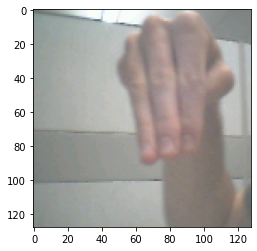

In [5]:
# set the file name accordingly
for image, label,path in test_dataloader:
    break
im_sample = (image[0].detach().cpu().numpy()).astype(np.int64)
np.save('../../ai8x-synthesis/tests/sample_asl.npy', im_sample)

plt.imshow((image[0].detach().cpu().permute(1, 2, 0)+128)/255)
print(label[0])

## **4.2 Synthesis**

### **Synthesize** a quantized model  
To execute these cell, change the virtual environment to ai8x-synthesis

In [2]:
%cd ../../ai8x-synthesis/
%run ai8xize.py --verbose --log --test-dir sdk/Examples/MAX78000/CNN --prefix asl_DA_new --checkpoint-file ../DA_ai8x-training/DA_tutorial/jupyter_logging/asl_dcd_train_adv_k8___2022.08.04-152648/aslclassifier_qat_best-q.pth.tar --config-file networks/classifier.yaml --device MAX78000 --softmax --compact-data --mexpress --timer 0 --fifo --display-checkpoint

[Errno 2] No such file or directory: '../../ai8x-synthesis/'
/home/geffencooper/Model_Development/ai8x-synthesis


WARNING:

Configuring device: MAX78000
Reading networks/classifier.yaml to configure network...
Reading ../DA_ai8x-training/DA_tutorial/jupyter_logging/asl_dcd_train_adv_k8___2022.08.04-152648/aslclassifier_qat_best-q.pth.tar to configure network weights...
Checkpoint for epoch 6, model aslclassifier_qat - weight and bias data:
 InCh OutCh  Weights         Quant Shift  Min  Max    Size Key                                       Bias       Quant  Min  Max Size Key
    3     8  (24, 3, 3)          8     0  -81   64     216 feature_extractor.conv1.op.weight         N/A            0    0    0    0 N/A                      
    8     8  (64, 3, 3)          8     0 -102   76     576 feature_extractor.conv2.op.weight         N/A            0    0    0    0 N/A                      
    8    16  (128, 3, 3)         8     0  -99   65    1152 feature_extractor.conv3.op.weight         N/A            0    0    0    0 N/A                      
   16    16  (256, 3, 3)         8     0  -84   50    2304 feature

Cannot check for updates for git branch "DA" from GitHub - Branch not found


WARNING:

Layer 11: `flatten` is not needed since input dimensions are 1x1.


WARNING:

Layer 12: `flatten` is not needed since input dimensions are 1x1.


Output()

asl_DA_new...


Output()

Output()